# Connectivity

In this notebook we look into program adjacencies, through the lens of the **Connectivity** metric. Our algorithm detects room adjacencies, and builds an adjacency matrix, from which a graph representation is then drawn. Using the generated graph, we can then qualify the repartition of program, and compare it across plans.

References:
- https://cran.r-project.org/web/packages/graphkernels/graphkernels.pdf
- https://graph-tool.skewed.de/
- Mathematics of Big Data
- The Fascinating World of Graph Theory

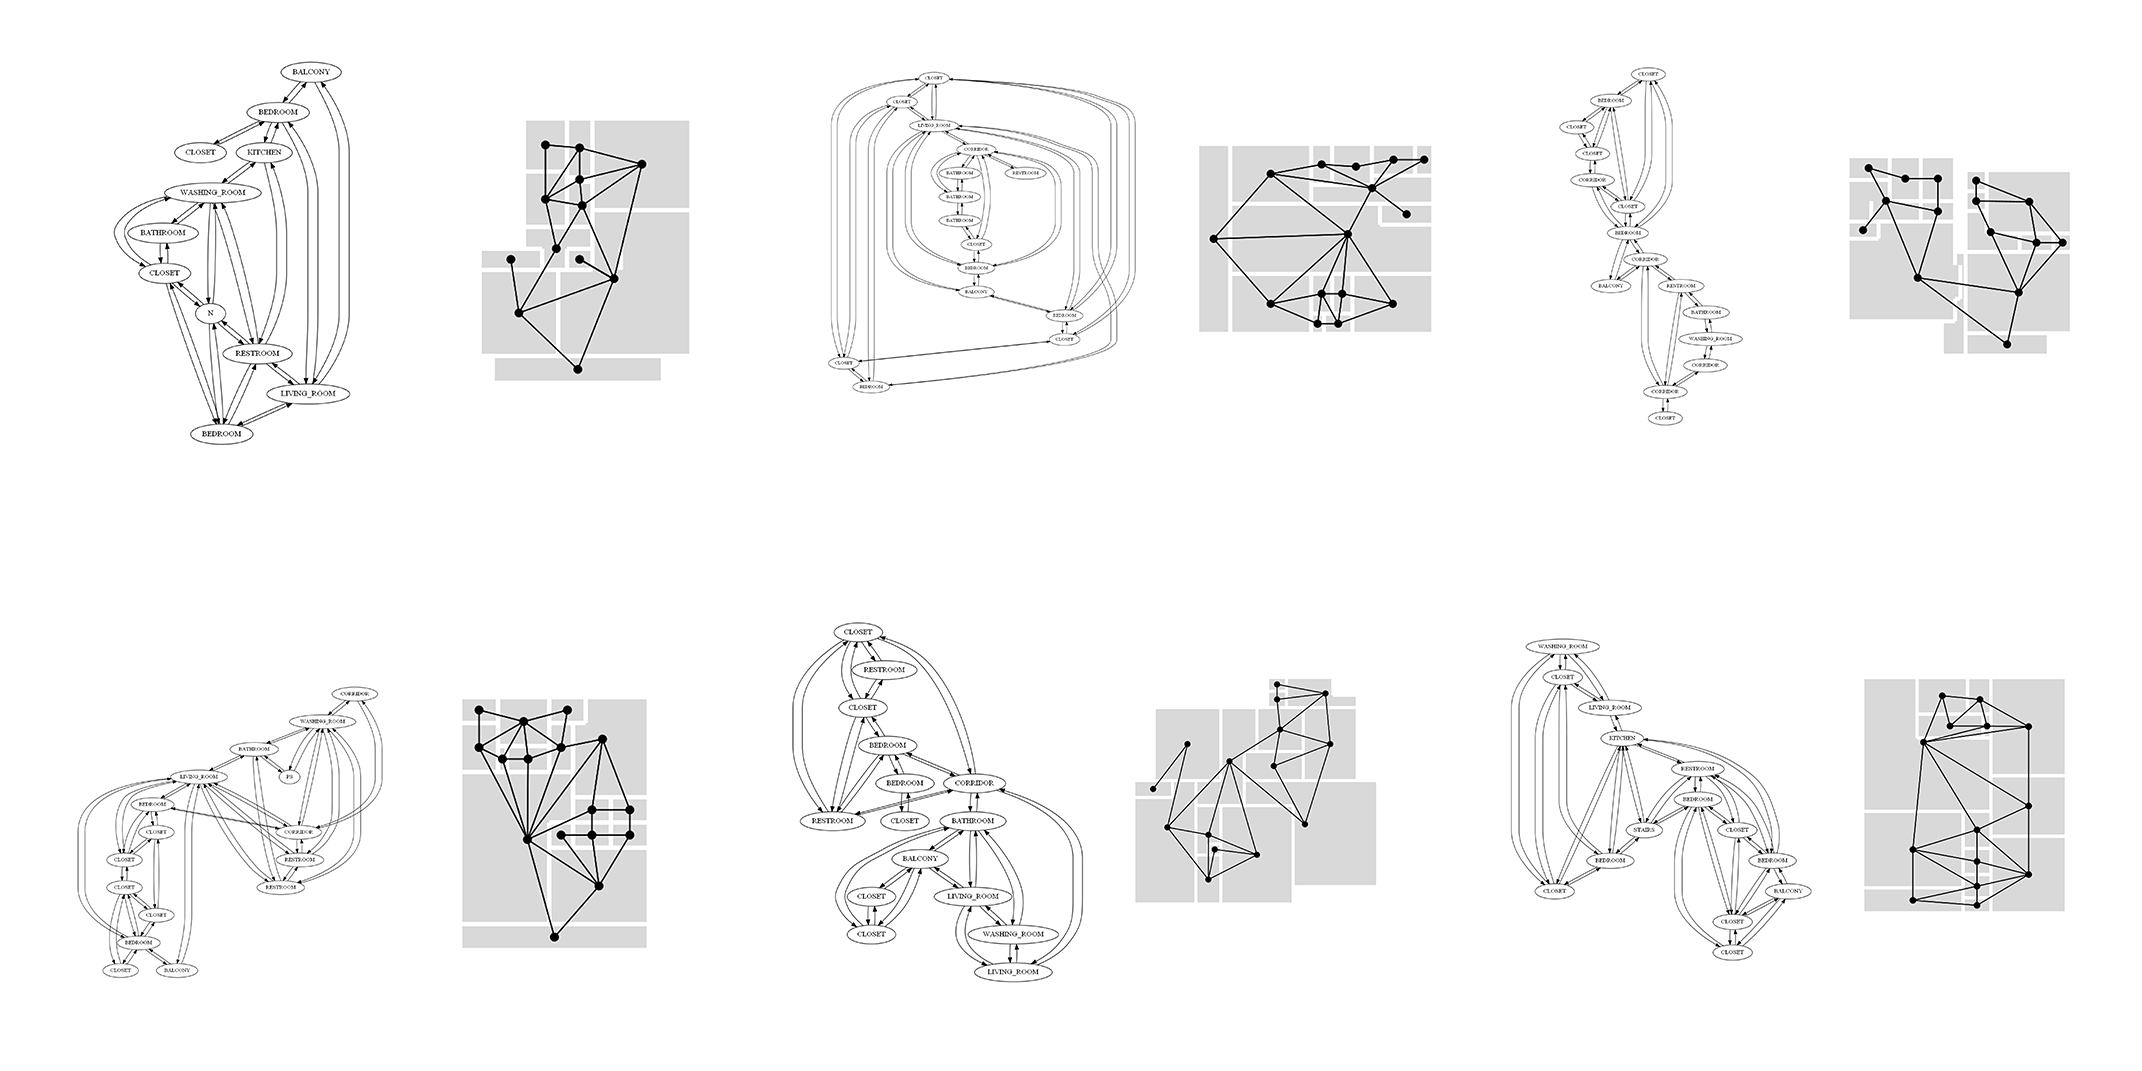

In [1]:
from IPython.display import Image
Image(filename='IMG/connectivity.png',width=1200, height=300)

In [2]:
#import pandas as pd
import cairo
import matplotlib.pylab as plt
import math
from IPython.display import Image
import numpy as np
import glob
import os
import os.path
import time
import cv2
import random
import ast
from shapely.geometry import LineString
import shapely
from graphviz import *
import pandas as pd

In [3]:
#import data_list
data_list=pd.read_csv("CSV/dataset_23_07.csv")
data_list.head()

,path_to_txt,corrected,rooms,plan_clean,network_corrected,rooms_img,walls_corrected
0,.\vector_graphics_floorplans\representation_pr...,corrected/1.txt,rooms/1.txt,plan_clean/1.png,network_corrected/1.png,rooms_png/1.png,walls_corrected/1.png
1,.\vector_graphics_floorplans\representation_pr...,corrected/2.txt,rooms/2.txt,plan_clean/2.png,network_corrected/2.png,rooms_png/2.png,walls_corrected/2.png
2,.\vector_graphics_floorplans\representation_pr...,corrected/4.txt,rooms/4.txt,plan_clean/4.png,network_corrected/4.png,rooms_png/4.png,walls_corrected/4.png
3,.\vector_graphics_floorplans\representation_pr...,corrected/5.txt,rooms/5.txt,plan_clean/5.png,network_corrected/5.png,rooms_png/5.png,walls_corrected/5.png
4,.\vector_graphics_floorplans\representation_pr...,corrected/6.txt,rooms/6.txt,plan_clean/6.png,network_corrected/6.png,rooms_png/6.png,walls_corrected/6.png


In [4]:
def draw_plan_w_rooms(id_image,data_list):

    #load corrected plan
    data = pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["corrected"], sep="\t",header = None)
    data.columns = ["xmin", "ymin", "xmax", "ymax","category","dump1","dump2"]
    categories=['living_room','kitchen','bedroom','bathroom','restroom','balcony','washing_room',"balcony","toilet"]
    
    try:
        #load room dataframe
        data_rooms=pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["rooms"], header=None , sep=':')
        rooms_ = []
        points_ = []
        for i in range(len(data_rooms)):
            a = data_rooms.loc[i].values
            try:
                points = ast.literal_eval(a[1])
            except:
                points = [[0.0,0.0]]
            points_.append(points)
            try:
                rooms = a[0].split(",")
            except:
                rooms = "NaN"
            rooms_.append(rooms)
        data_room = pd.DataFrame()
        data_room["rooms"] = rooms_
        data_room["points"] = points_

        #draw rooms
        rooms_=['living_room','kitchen','bedroom','bathroom','restroom','corridor','washing_room',"entrance",'balcony','closet','PS']
        rooms_colors_=[
            #living room
            [1.000, 0.000, 1.000],
            #kitchen
            [1.000, 0.271, 0.000],
            #bedroom
            [0.000, 1.000, 0.000],
            #bathroom
            [0.000, 1.000, 1.000],
            #restroom
            [0.7,0.1,0.2],
            #corridor
            [1.000, 1.000, 0.000],
            #washing_room
            [0.000, 0.749, 1.000],
            #entrance
            [0.000, 0.000, 1.000],
            #balcony
            [0.827, 0.827, 0.827],
            #closet
            [0.502, 0.000, 0.000],
            #PS
            [0.412, 0.412, 0.412]]

        padding = 50
        stroke = 3

        xmin = np.min(data["xmin"])
        xmax = np.max(data["xmax"])
        ymin = np.min(data["ymin"]) 
        ymax = np.max(data["ymax"])

        WIDTH = int(xmax - xmin + padding)
        HEIGHT = int(ymax - ymin + padding)

        surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
        ctx = cairo.Context(surface)

        cx_ = []
        cy_ = []

        cx_pt = []
        cy_pt = []
#SET BACKGROUND---------------
        ctx.rectangle(0.0, 0.0, WIDTH,HEIGHT)
        ctx.set_source_rgb(1, 1, 1)
        ctx.fill()

#COLOR ROOMS--------------------------------------------------------------------------------------------

        #DRAW ROOMS LIGHT GREY
        for i in range(len(data_room)):

            ctx.move_to(data_room.loc[i]["points"][0][0]+padding/2-xmin, data_room.loc[i]["points"][0][1]+padding/2-ymin)

            for j in range(len(data_room.loc[i]["points"])):

                ctx.line_to(data_room.loc[i]["points"][j][0]+padding/2-xmin, data_room.loc[i]["points"][j][1]+padding/2-ymin)

            ctx.set_source_rgb(0.85, 0.85, 0.85)
            ctx.close_path()
            ctx.fill()

#NETWORK--------------------------------------------------------------------------------------------
        #DRAW ROOM Centers
        centers = []
        contours = []
        for i in range(len(data_room)):

            contour = data_room.loc[i]["points"]
            cX = np.mean(np.array(contour)[:,0])+padding/2-xmin
            cY = np.mean(np.array(contour)[:,1])+padding/2-ymin

            centers.append([cX,cY])

            ctx.arc(cX, cY, 4, 0, 2*math.pi)
            ctx.set_source_rgb(1, 0, 0)
            ctx.fill()

        #DRAW LINK LINES
        for i in range(len(centers)):
            for j in range(len(centers)):
                ctx.move_to(centers[i][0], centers[i][1])
                ctx.line_to(centers[i][0], centers[i][1])
                ctx.line_to(centers[j][0], centers[j][1])
                ctx.close_path()
                ctx.set_source_rgba(1, 0, 0,0.2)
                ctx.set_line_width(1)
                ctx.stroke()
                
#WALLS & OPENING-----------------------------------------------------------------------------
    #DRAW WALLS
        for i in range(len(data)):
            if(data.loc[i]["category"]=="wall"):
                ctx.move_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
                ctx.line_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
                ctx.line_to(data.loc[i]["xmax"]+padding/2-xmin, data.loc[i]["ymax"]+padding/2-ymin)
                ctx.close_path() 
                ctx.set_source_rgb(0,0,0)
                ctx.set_line_width(3)
                ctx.set_line_cap(cairo.LINE_CAP_SQUARE)
                ctx.stroke()

#     #DRAW OPENING/DOORS & CENTERS
#         for i in range(len(data)):
#             if(data.loc[i]["category"]== "door"):
#                 ctx.move_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
#                 ctx.line_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
#                 ctx.line_to(data.loc[i]["xmax"]+padding/2-xmin, data.loc[i]["ymax"]+padding/2-ymin)
#                 ctx.close_path()
#                 ctx.set_source_rgb(0.9, 0.9, 0.9)
#                 ctx.set_line_width(3.5)
#                 ctx.stroke()

        surface.write_to_png("IMG/room_print/"+str(id_image)+".png") 
        img_ = cv2.cvtColor(cv2.imread("IMG/room_print/"+str(id_image)+".png"),cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(20,10))
        plt.axis("off")
        plt.imshow(img_)
    except:
        pass

### Find Adjacency Matrix

In [14]:
id_image = 350
data = pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["corrected"], sep="\t",header = None)
data_rooms=pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["rooms"], header=None , sep=':')

In [15]:
def get_points(data_rooms):
    # Get Points
    rooms_ = []
    points_ = []
    for i in range(len(data_rooms)):
        a = data_rooms.loc[i].values
        try:
            points = ast.literal_eval(a[1])
        except:
            points = [[0.0,0.0]]
        points_.append(points)
        try:
            rooms = a[0].split(",")
        except:
            rooms = "NaN"
        rooms_.append(rooms)
    data_room = pd.DataFrame()
    data_room["rooms"] = rooms_
    data_room["points"] = points_
    
    PTS = []
    
    for i in range(len(points_)):
        PTS.append(list(points_[i]))
        
    
    return PTS, rooms_

In [16]:
room_polylines, room_labels = get_points(data_rooms)

In [17]:
#find adjacencies
adjacencies = []

adj_matrix = np.zeros((len(room_labels),len(room_labels)))

for i in range(len(room_polylines)):
    #line1 = LineString(room_polylines[i])
    pol1 = shapely.geometry.Polygon(room_polylines[i])
    for j in range(len(room_polylines)):
        if(i!=j):
            #line2 = LineString(room_polylines[j])
            pol2 = shapely.geometry.Polygon(room_polylines[j])
            #print(str(line1.intersection(line2)))
            if(str(pol1.intersection(pol2))[0]=="L"):
                adjacencies.append([i,j])
                adj_matrix[i,j]=1

In [20]:
#draw adjacencies

def draw_plan_w_rooms(id_image,data_list, adjacencies, adj_matrix, room_labels,save_):

    #load corrected plan
    data = pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["corrected"], sep="\t",header = None)
    data.columns = ["xmin", "ymin", "xmax", "ymax","category","dump1","dump2"]
    categories=['living_room','kitchen','bedroom','bathroom','restroom','balcony','washing_room',"balcony","toilet"]

    #load room dataframe
    data_rooms=pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["rooms"], header=None , sep=':')
    rooms_ = []
    points_ = []
    for i in range(len(data_rooms)):
        a = data_rooms.loc[i].values
        try:
            points = ast.literal_eval(a[1])
        except:
            points = [[0.0,0.0]]
        points_.append(points)
        try:
            rooms = a[0].split(",")
        except:
            rooms = "NaN"
        rooms_.append(rooms)
    data_room = pd.DataFrame()
    data_room["rooms"] = rooms_
    data_room["points"] = points_

    #draw rooms
    rooms_=['living_room','kitchen','bedroom','bathroom','restroom','corridor','washing_room',"entrance",'balcony','closet','PS']
    rooms_colors_=[
        #living room
        [1.000, 0.000, 1.000],
        #kitchen
        [1.000, 0.271, 0.000],
        #bedroom
        [0.000, 1.000, 0.000],
        #bathroom
        [0.000, 1.000, 1.000],
        #restroom
        [0.7,0.1,0.2],
        #corridor
        [1.000, 1.000, 0.000],
        #washing_room
        [0.000, 0.749, 1.000],
        #entrance
        [0.000, 0.000, 1.000],
        #balcony
        [0.827, 0.827, 0.827],
        #closet
        [0.502, 0.000, 0.000],
        #PS
        [0.412, 0.412, 0.412]]

    padding = 50
    stroke = 3

    xmin = np.min(data["xmin"])
    xmax = np.max(data["xmax"])
    ymin = np.min(data["ymin"]) 
    ymax = np.max(data["ymax"])

    WIDTH = int(xmax - xmin + padding)
    HEIGHT = int(ymax - ymin + padding)

    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
    ctx = cairo.Context(surface)

    cx_ = []
    cy_ = []

    cx_pt = []
    cy_pt = []
    
#SET BACKGROUND---------------

    ctx.rectangle(0.0, 0.0, WIDTH,HEIGHT)
    ctx.set_source_rgb(1, 1, 1)
    ctx.fill()

#COLOR ROOMS--------------------------------------------------------------------------------------------

    #DRAW ROOMS LIGHT GREY
    for i in range(len(data_room)):

        ctx.move_to(data_room.loc[i]["points"][0][0]+padding/2-xmin, data_room.loc[i]["points"][0][1]+padding/2-ymin)

        for j in range(len(data_room.loc[i]["points"])):

            ctx.line_to(data_room.loc[i]["points"][j][0]+padding/2-xmin, data_room.loc[i]["points"][j][1]+padding/2-ymin)

        ctx.set_source_rgb(0.85, 0.85, 0.85)
        ctx.close_path()
        ctx.fill()

#NETWORK--------------------------------------------------------------------------------------------
    #DRAW ROOM Centers
    centers = []
    contours = []
    for i in range(len(data_room)):

        contour = data_room.loc[i]["points"]
        cX = np.mean(np.array(contour)[:,0])+padding/2-xmin
        cY = np.mean(np.array(contour)[:,1])+padding/2-ymin

        centers.append([cX,cY])

        ctx.arc(cX, cY, 4, 0, 2*math.pi)
        ctx.set_source_rgb(1, 0, 0)
        ctx.fill()

    #DRAW LINK LINES
    for i in range(len(adjacencies)):
        #for j in range(len(centers)):
        ctx.move_to(centers[adjacencies[i][0]][0], centers[adjacencies[i][0]][1])
        ctx.line_to(centers[adjacencies[i][0]][0], centers[adjacencies[i][0]][1])
        ctx.line_to(centers[adjacencies[i][1]][0], centers[adjacencies[i][1]][1])
        ctx.close_path()
        ctx.set_source_rgba(1, 0, 0,0.2)
        ctx.set_line_width(1)
        ctx.stroke()

#WALLS & OPENING-----------------------------------------------------------------------------
#DRAW WALLS
    for i in range(len(data)):
        if(data.loc[i]["category"]=="wall"):
            ctx.move_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
            ctx.line_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
            ctx.line_to(data.loc[i]["xmax"]+padding/2-xmin, data.loc[i]["ymax"]+padding/2-ymin)
            ctx.close_path() 
            ctx.set_source_rgb(0,0,0)
            ctx.set_line_width(3)
            ctx.set_line_cap(cairo.LINE_CAP_SQUARE)
            ctx.stroke()

#     #DRAW OPENING/DOORS & CENTERS
#         for i in range(len(data)):
#             if(data.loc[i]["category"]== "door"):
#                 ctx.move_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
#                 ctx.line_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
#                 ctx.line_to(data.loc[i]["xmax"]+padding/2-xmin, data.loc[i]["ymax"]+padding/2-ymin)
#                 ctx.close_path()
#                 ctx.set_source_rgb(0.9, 0.9, 0.9)
#                 ctx.set_line_width(3.5)
#                 ctx.stroke()

    surface.write_to_png("IMG/room_print/"+str(id_image)+".png") 
    img_ = cv2.cvtColor(cv2.imread("IMG/room_print/"+str(id_image)+".png"),cv2.COLOR_BGR2RGB)
    
    room_labels_ = []
    for label in room_labels:
        room_labels_.append(label[0])
    #print(room_labels_)
    
    fig = plt.figure(figsize=(20, 6))

    ax1 = fig.add_subplot(131)
    ax1.imshow(img_)
    ax1.axis("off")
    
    if(save_==True):
        cv2.imwrite('IMG/save_plan/'+str(id_image)+'.png',img_)
    
    ax2 = fig.add_subplot(132)
    ax2.set_yticks(range(len(room_labels_)))
    ax2.set_yticklabels([str(room_labels_[x]) for x in range(len(room_labels_))], rotation=45)
    
    ax2.set_xticks(range(len(room_labels_)))
    ax2.set_xticklabels([str(room_labels_[x]) for x in range(len(room_labels_))], rotation=45)
    
    ax2.imshow(adj_matrix,cmap="Greys")

    ax2.set_title("Adjacency Matrix")
    
    
    #Intialize Graph
    graph = Digraph(comment='Floor Plan', format='png')
    #graph.attr(rankdir='LR', size='15,5')

    #Append rooms as nodes
    for i in range(len(room_labels)):
        graph.node(str(i),room_labels[i][0].upper())

    #Append connections as edges
    for i in range(len(adjacencies)):
        graph.edge(str(adjacencies[i][0]),str(adjacencies[i][1]))
    
    graph.render('IMG/graphs/graph_1', view=False)
    
    plt.rcParams['figure.dpi']= 200
    
    ax3 = fig.add_subplot(133)
    #ax3.set_rcParams['figure.dpi']= 200
    ax3.imshow(cv2.imread('IMG/graphs/graph_1.png'), interpolation='none')
    
    if(save_==True):
        img_net = cv2.imread('IMG/graphs/graph_1.png')
        cv2.imwrite('IMG/save_net/'+str(id_image)+'.png',img_net)
        
    ax3.axis('off')

    plt.show()
    
    return fig

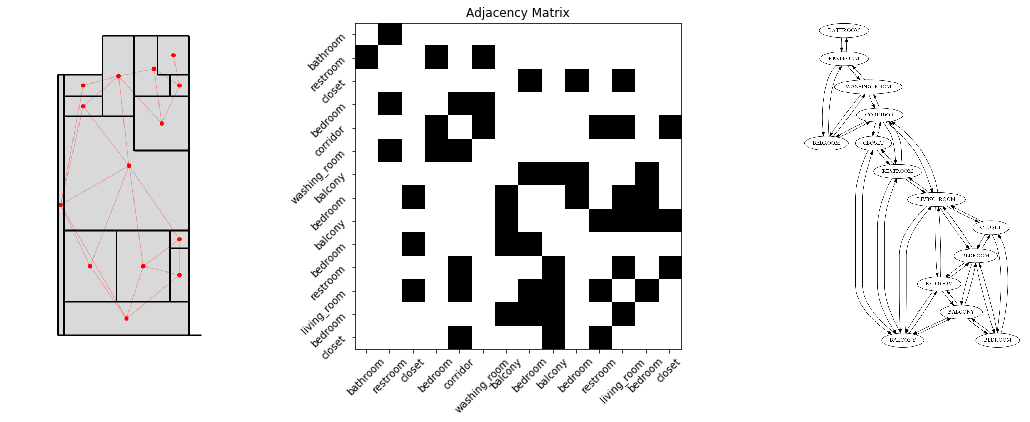

In [21]:
fig = draw_plan_w_rooms(id_image,data_list,adjacencies, adj_matrix, room_labels, save_=False)

### Draw Plan w Graph

In [22]:
#draw adjacencies

def draw_plan_w_graph(id_image,data_list, adjacencies, adj_matrix, room_labels,save_):

    #load corrected plan
    data = pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["corrected"], sep="\t",header = None)
    data.columns = ["xmin", "ymin", "xmax", "ymax","category","dump1","dump2"]
    categories=['living_room','kitchen','bedroom','bathroom','restroom','balcony','washing_room',"balcony","toilet"]

    #load room dataframe
    data_rooms=pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["rooms"], header=None , sep=':')
    rooms_ = []
    points_ = []
    for i in range(len(data_rooms)):
        a = data_rooms.loc[i].values
        try:
            points = ast.literal_eval(a[1])
        except:
            points = [[0.0,0.0]]
        points_.append(points)
        try:
            rooms = a[0].split(",")
        except:
            rooms = "NaN"
        rooms_.append(rooms)
    data_room = pd.DataFrame()
    data_room["rooms"] = rooms_
    data_room["points"] = points_

    #draw rooms
    rooms_=['living_room','kitchen','bedroom','bathroom','restroom','corridor','washing_room',"entrance",'balcony','closet','PS']
    rooms_colors_=[
        #living room
        [1.000, 0.000, 1.000],
        #kitchen
        [1.000, 0.271, 0.000],
        #bedroom
        [0.000, 1.000, 0.000],
        #bathroom
        [0.000, 1.000, 1.000],
        #restroom
        [0.7,0.1,0.2],
        #corridor
        [1.000, 1.000, 0.000],
        #washing_room
        [0.000, 0.749, 1.000],
        #entrance
        [0.000, 0.000, 1.000],
        #balcony
        [0.827, 0.827, 0.827],
        #closet
        [0.502, 0.000, 0.000],
        #PS
        [0.412, 0.412, 0.412]]

    padding = 50
    stroke = 3

    xmin = np.min(data["xmin"])
    xmax = np.max(data["xmax"])
    ymin = np.min(data["ymin"]) 
    ymax = np.max(data["ymax"])

    WIDTH = int(xmax - xmin + padding)
    HEIGHT = int(ymax - ymin + padding)

    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
    ctx = cairo.Context(surface)

    cx_ = []
    cy_ = []

    cx_pt = []
    cy_pt = []
    
#SET BACKGROUND---------------

    ctx.rectangle(0.0, 0.0, WIDTH,HEIGHT)
    ctx.set_source_rgba(1, 1, 1,0)
    ctx.fill()

#COLOR ROOMS--------------------------------------------------------------------------------------------

    #DRAW ROOMS LIGHT GREY
    for i in range(len(data_room)):

        ctx.move_to(data_room.loc[i]["points"][0][0]+padding/2-xmin, data_room.loc[i]["points"][0][1]+padding/2-ymin)

        for j in range(len(data_room.loc[i]["points"])):

            ctx.line_to(data_room.loc[i]["points"][j][0]+padding/2-xmin, data_room.loc[i]["points"][j][1]+padding/2-ymin)

        ctx.set_source_rgb(0.85, 0.85, 0.85)
        ctx.close_path()
        ctx.fill()

#WALLS & OPENING-----------------------------------------------------------------------------
#DRAW WALLS
    for i in range(len(data)):
        if(data.loc[i]["category"]=="wall"):
            ctx.set_line_cap(cairo.LineCap.SQUARE)
            ctx.move_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
            ctx.line_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
            ctx.line_to(data.loc[i]["xmax"]+padding/2-xmin, data.loc[i]["ymax"]+padding/2-ymin)
            ctx.close_path() 
            ctx.set_source_rgb(1,1,1)
            ctx.set_line_width(6)
            ctx.stroke()

#NETWORK--------------------------------------------------------------------------------------------
    #DRAW ROOM Centers
    centers = []
    contours = []
    for i in range(len(data_room)):
        contour = data_room.loc[i]["points"]
        cX = np.mean(np.array(contour)[:,0])+padding/2-xmin
        cY = np.mean(np.array(contour)[:,1])+padding/2-ymin
        centers.append([cX,cY])
        ctx.arc(cX, cY, 6, 0, 2*math.pi)
        ctx.set_source_rgb(0, 0, 0)
        ctx.fill()

    #DRAW LINK LINES
    for i in range(len(adjacencies)):
        ctx.move_to(centers[adjacencies[i][0]][0], centers[adjacencies[i][0]][1])
        ctx.line_to(centers[adjacencies[i][0]][0], centers[adjacencies[i][0]][1])
        ctx.line_to(centers[adjacencies[i][1]][0], centers[adjacencies[i][1]][1])
        ctx.close_path()
        ctx.set_source_rgb(0, 0, 0)
        ctx.set_line_width(1.5)
        ctx.stroke()

    surface.write_to_png("IMG/adj_1000/"+str(id_image)+".png") 
    

In [23]:
def draw_graph(id_image,data_list, adjacencies, adj_matrix, room_labels,save_):
    #Intialize Graph
    graph = Digraph(comment='Floor Plan', format='png')
    #graph.attr(rankdir='LR', size='15,5')

    #Append rooms as nodes
    for i in range(len(room_labels)):
        graph.node(str(i),room_labels[i][0].upper())

    #Append connections as edges
    for i in range(len(adjacencies)):
        graph.edge(str(adjacencies[i][0]),str(adjacencies[i][1]))
    
    graph.render('IMG/graph_1000/'+str(id_image), view=False)

In [24]:
def get_adjacencies(id_image,data_list,save_):
    #id_image = 370
    data = pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["corrected"], sep="\t",header = None)
    data_rooms=pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["rooms"], header=None , sep=':')

    room_polylines, room_labels = get_points(data_rooms)
    
    ##### find adjacencies
    adjacencies = []

    adj_matrix = np.zeros((len(room_labels),len(room_labels)))

    for i in range(len(room_polylines)):
        pol1 = shapely.geometry.Polygon(room_polylines[i])
        for j in range(len(room_polylines)):
            if(i!=j):
                pol2 = shapely.geometry.Polygon(room_polylines[j])
                if(str(pol1.intersection(pol2))[0]=="L"):
                    adjacencies.append([i,j])
                    adj_matrix[i,j]=1
                    
    draw_graph(id_image,data_list, adjacencies, adj_matrix, room_labels,save_)
    
    return adjacencies

In [25]:
for id_image in range(0,20):
    adj = get_adjacencies(id_image,data_list,save_=True)

### All together

In [27]:
data_list=pd.read_csv("CSV/dataset_23_07.csv")
data_list.head()

,path_to_txt,corrected,rooms,plan_clean,network_corrected,rooms_img,walls_corrected
0,.\vector_graphics_floorplans\representation_pr...,corrected/1.txt,rooms/1.txt,plan_clean/1.png,network_corrected/1.png,rooms_png/1.png,walls_corrected/1.png
1,.\vector_graphics_floorplans\representation_pr...,corrected/2.txt,rooms/2.txt,plan_clean/2.png,network_corrected/2.png,rooms_png/2.png,walls_corrected/2.png
2,.\vector_graphics_floorplans\representation_pr...,corrected/4.txt,rooms/4.txt,plan_clean/4.png,network_corrected/4.png,rooms_png/4.png,walls_corrected/4.png
3,.\vector_graphics_floorplans\representation_pr...,corrected/5.txt,rooms/5.txt,plan_clean/5.png,network_corrected/5.png,rooms_png/5.png,walls_corrected/5.png
4,.\vector_graphics_floorplans\representation_pr...,corrected/6.txt,rooms/6.txt,plan_clean/6.png,network_corrected/6.png,rooms_png/6.png,walls_corrected/6.png


In [28]:
def get_adjacencies(id_image,data_list,save_):
    #id_image = 370
    data = pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["corrected"], sep="\t",header = None)
    data_rooms=pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["rooms"], header=None , sep=':')

    room_polylines, room_labels = get_points(data_rooms)
    
    ##### find adjacencies
    adjacencies = []

    adj_matrix = np.zeros((len(room_labels),len(room_labels)))

    for i in range(len(room_polylines)):
        #line1 = LineString(room_polylines[i])
        pol1 = shapely.geometry.Polygon(room_polylines[i])
        for j in range(len(room_polylines)):
            if(i!=j):
                #line2 = LineString(room_polylines[j])
                pol2 = shapely.geometry.Polygon(room_polylines[j])
                #print(str(line1.intersection(line2)))
                if(str(pol1.intersection(pol2))[0]=="L"):
                    adjacencies.append([i,j])
                    adj_matrix[i,j]=1
                    
    fig = draw_plan_w_rooms(id_image,data_list, adjacencies, adj_matrix, room_labels,save_)
    
    if(save_==True):
        fig.savefig('IMG/adj/fig'+str(id_image)+'.png')
    
    return adjacencies

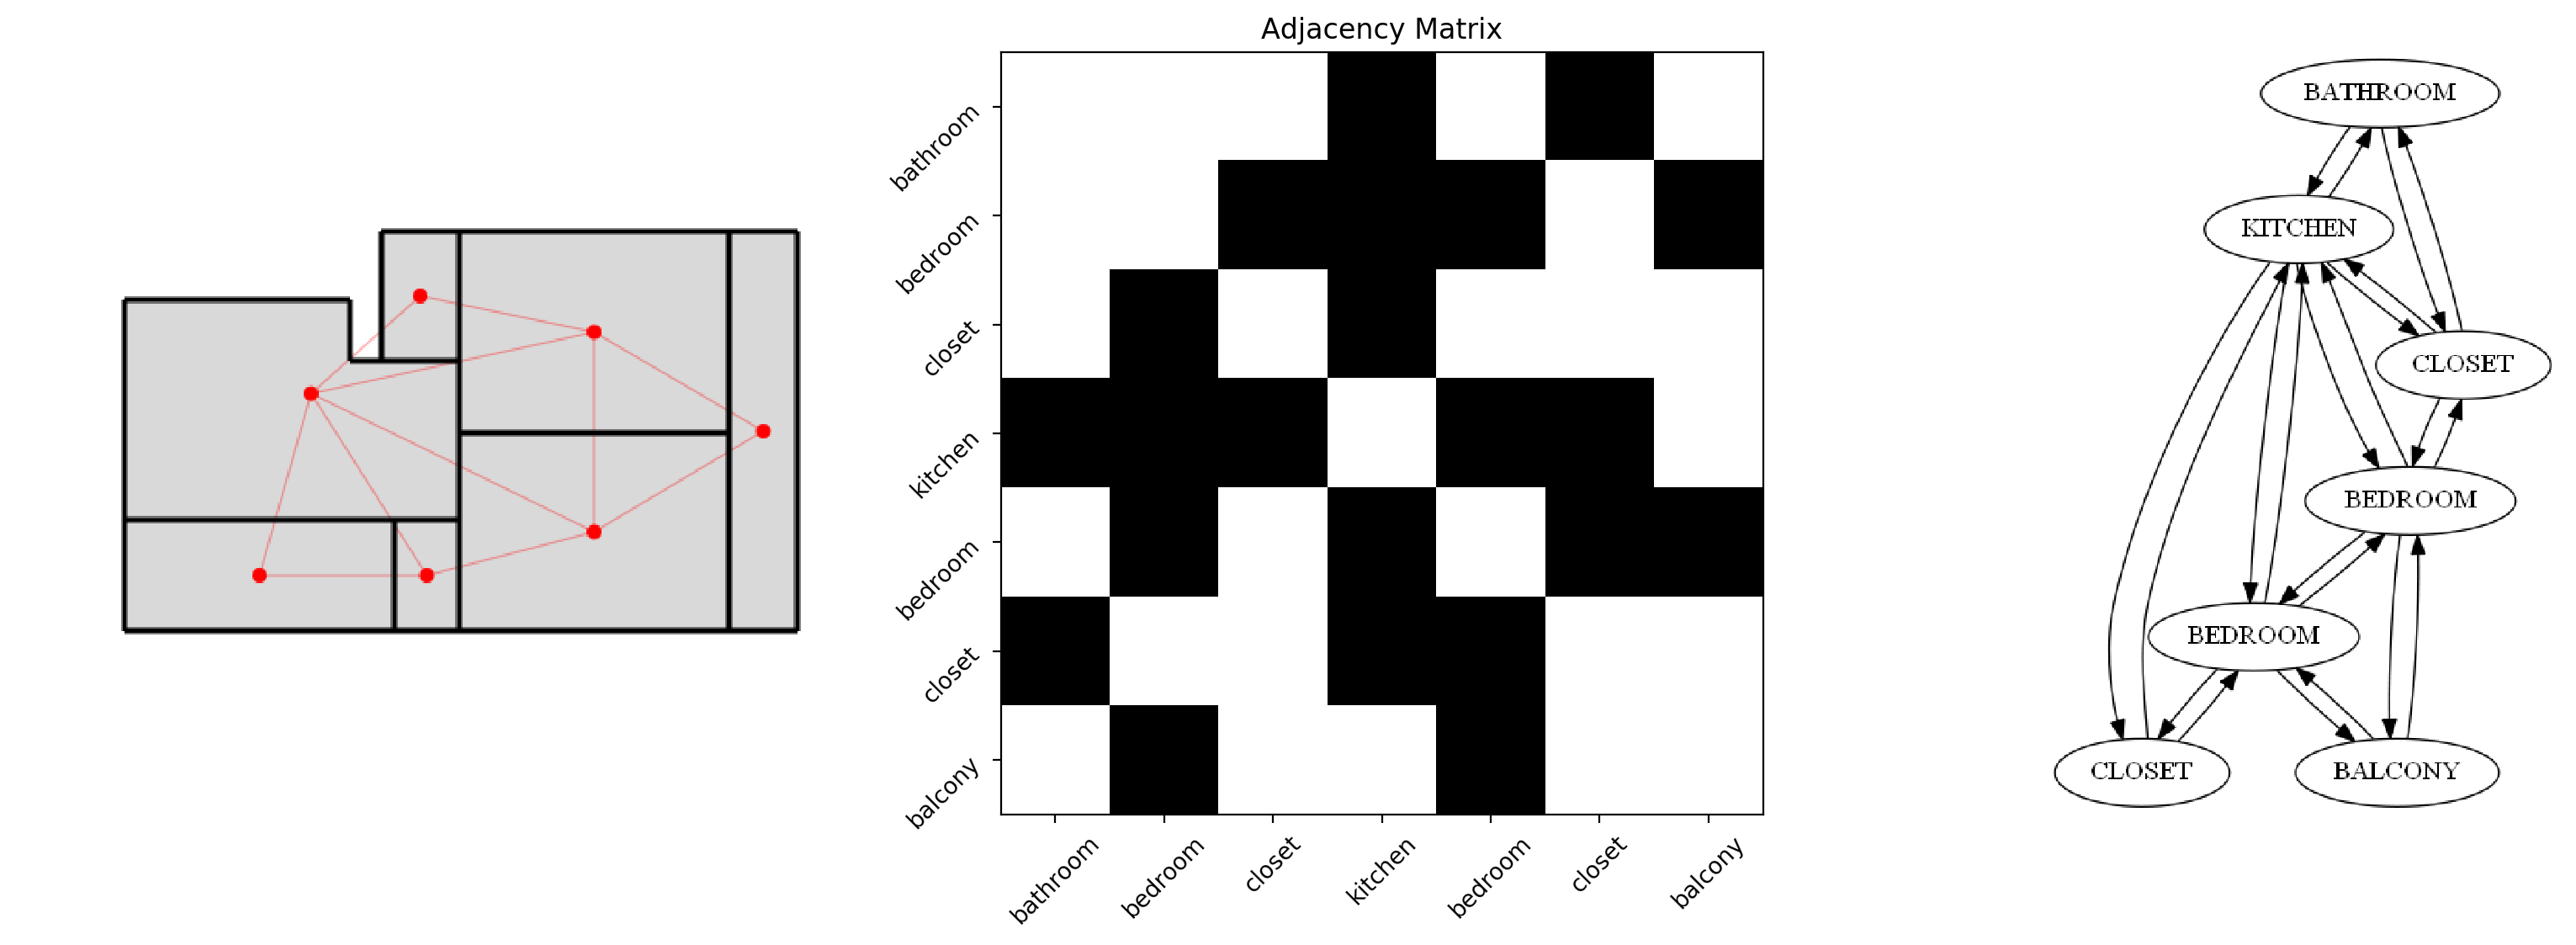

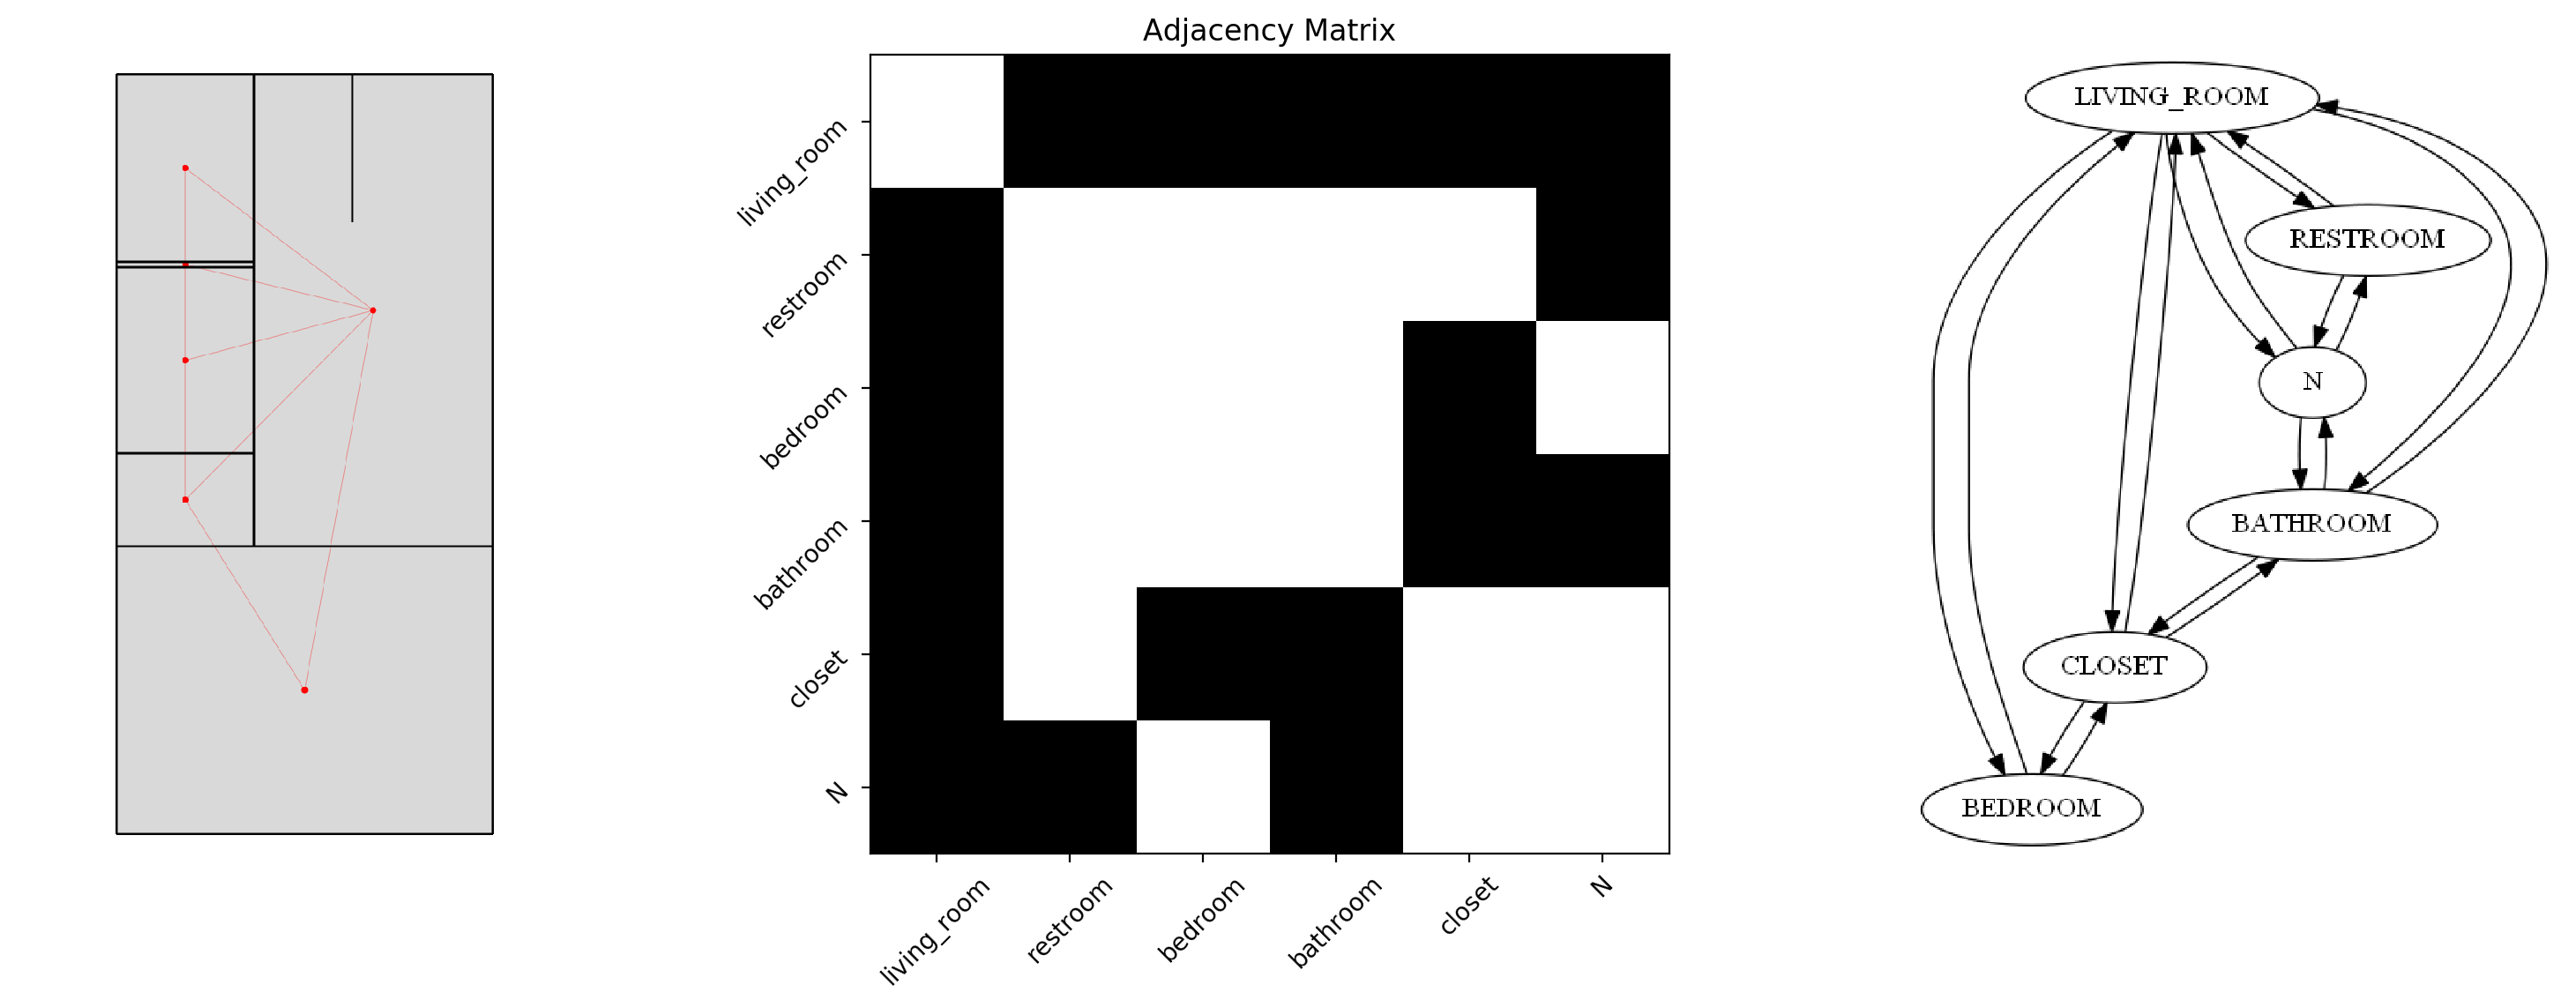

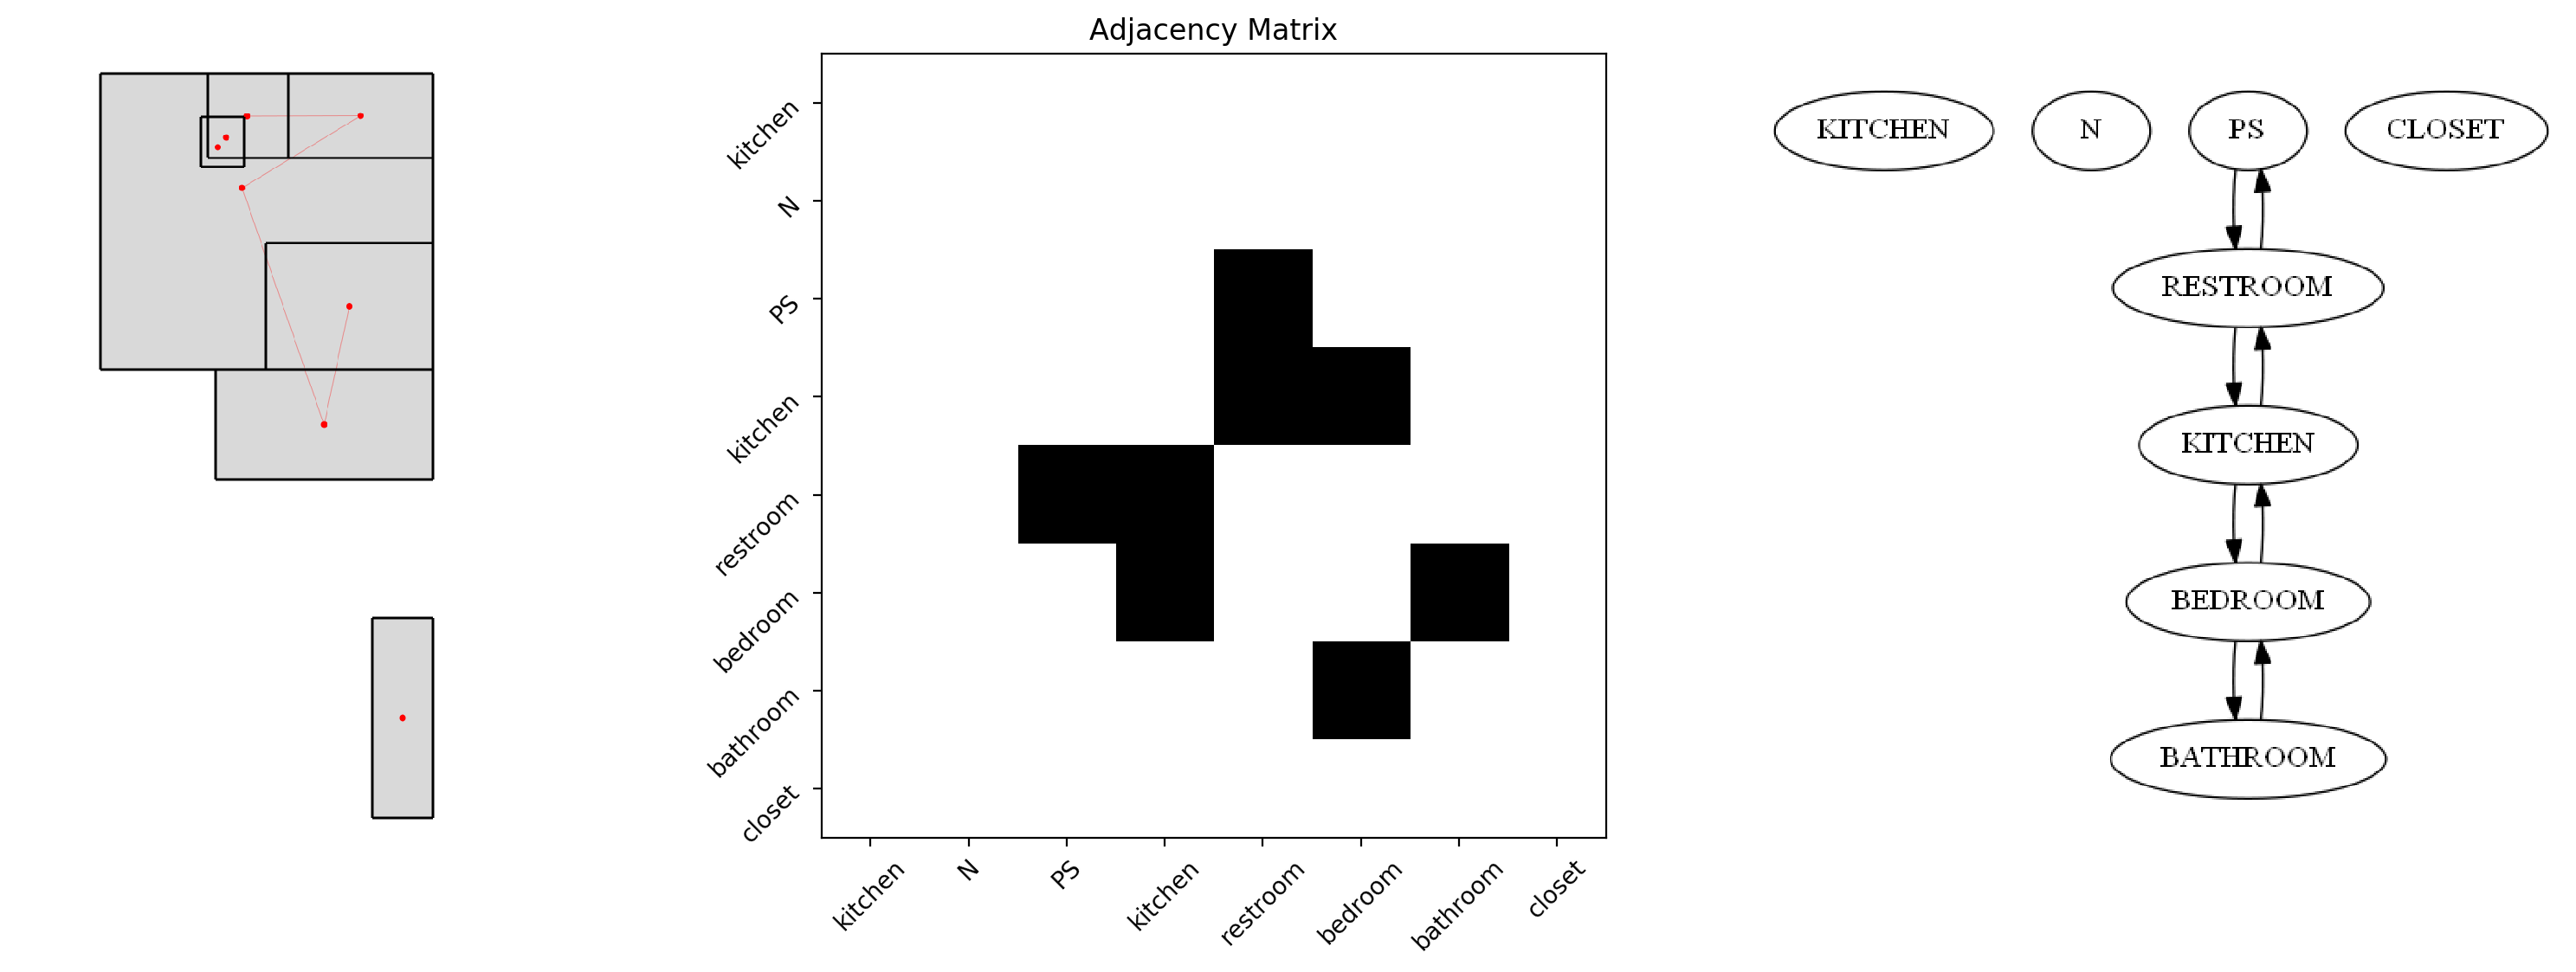

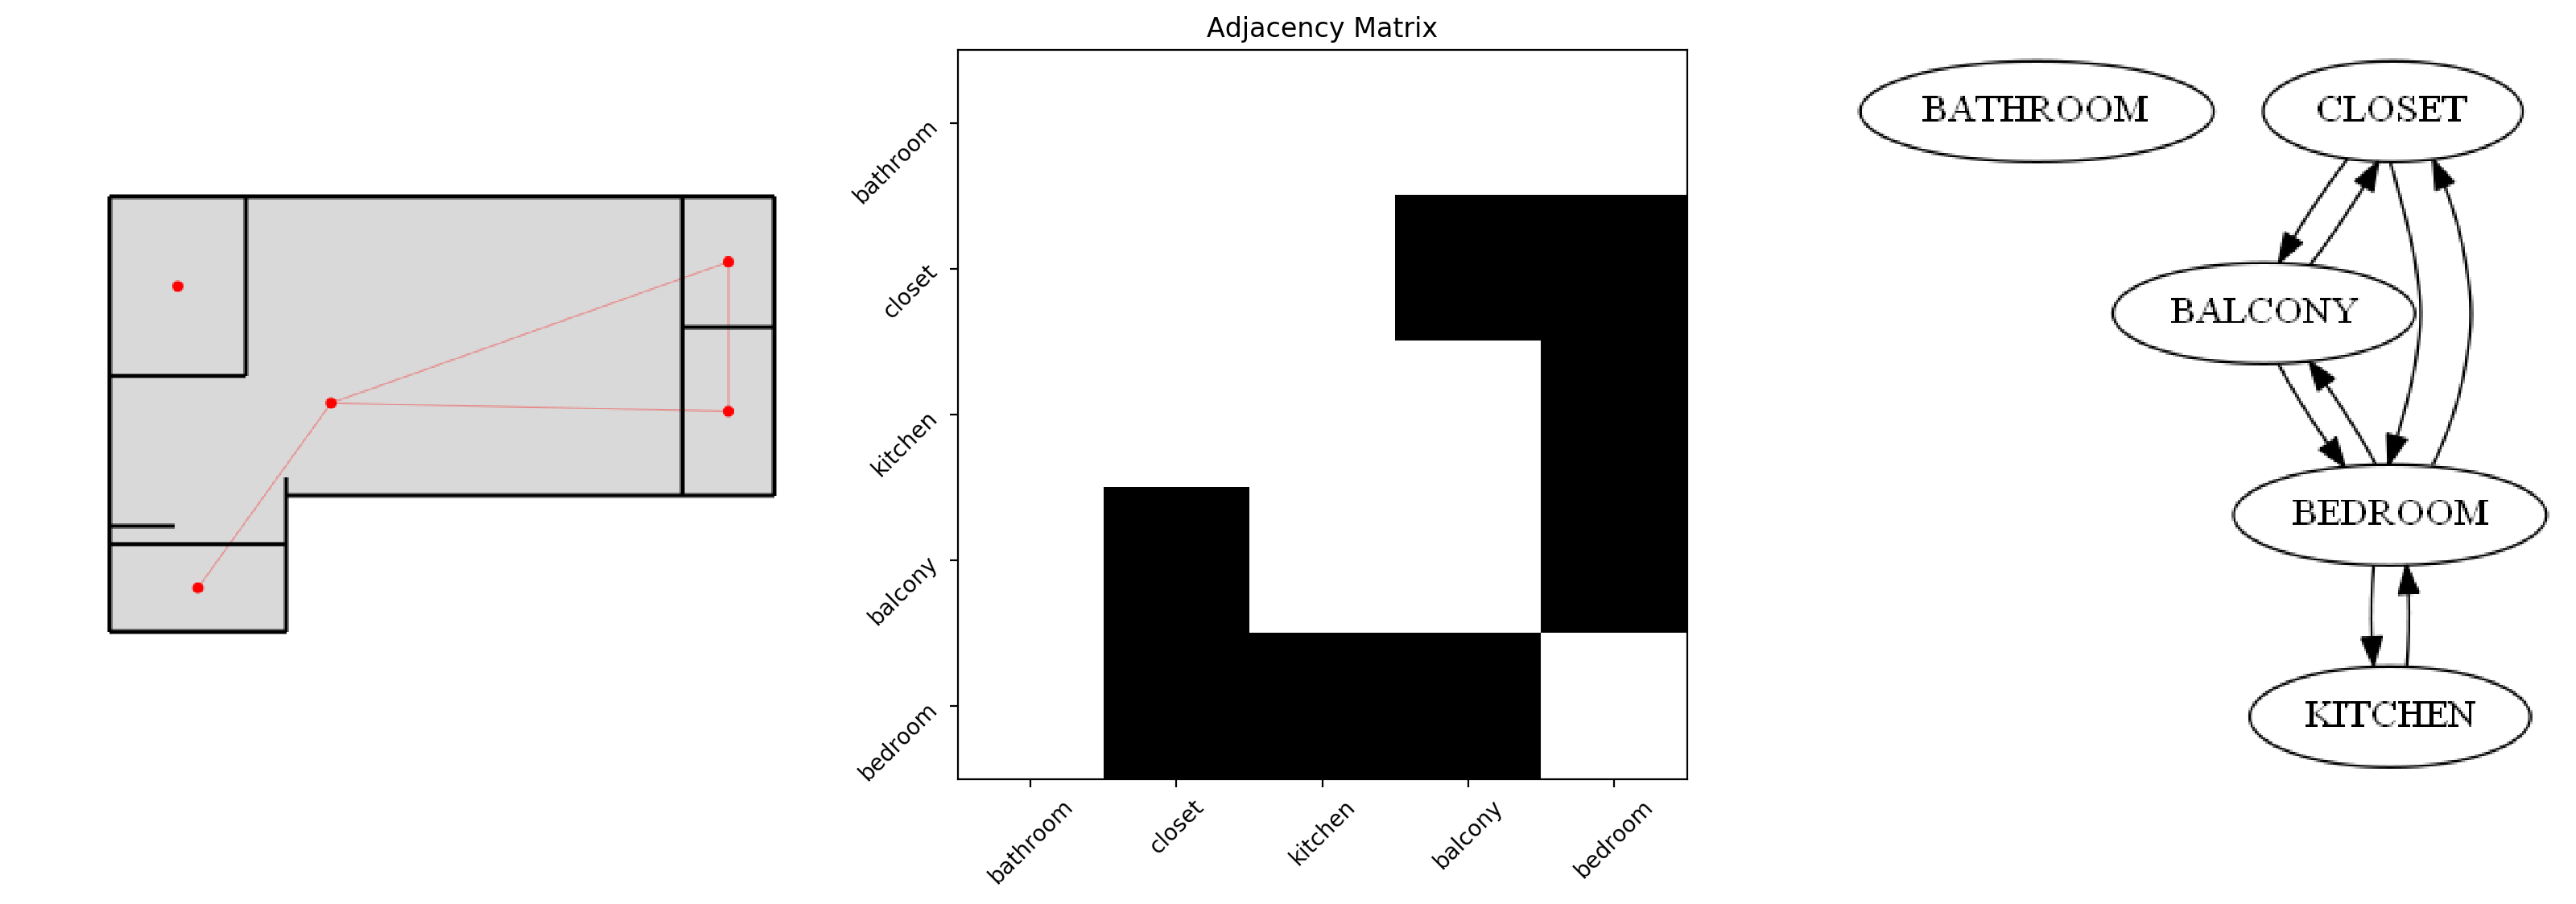

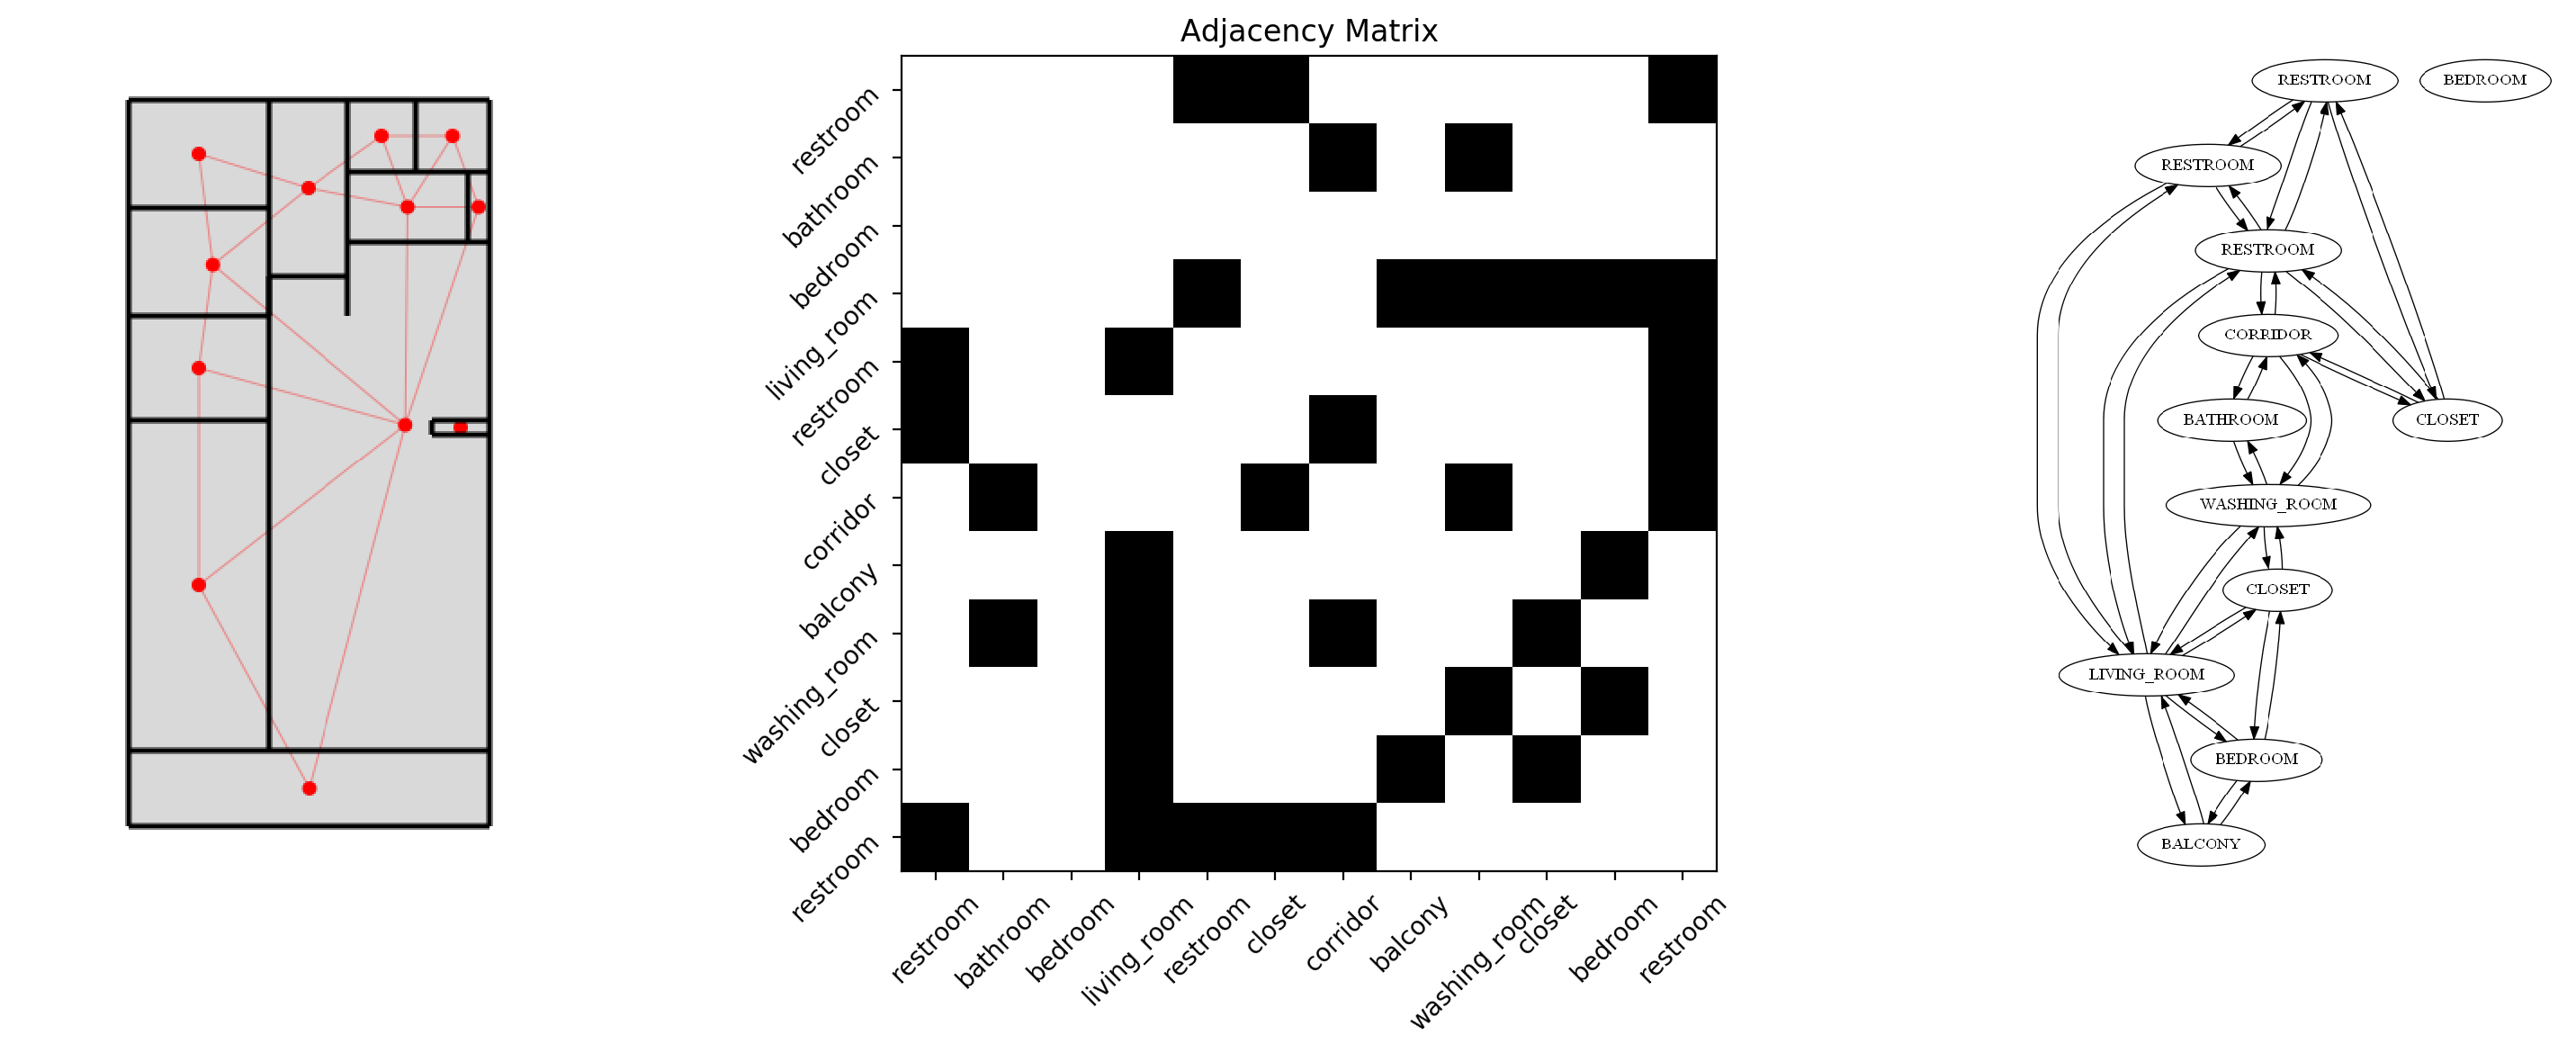

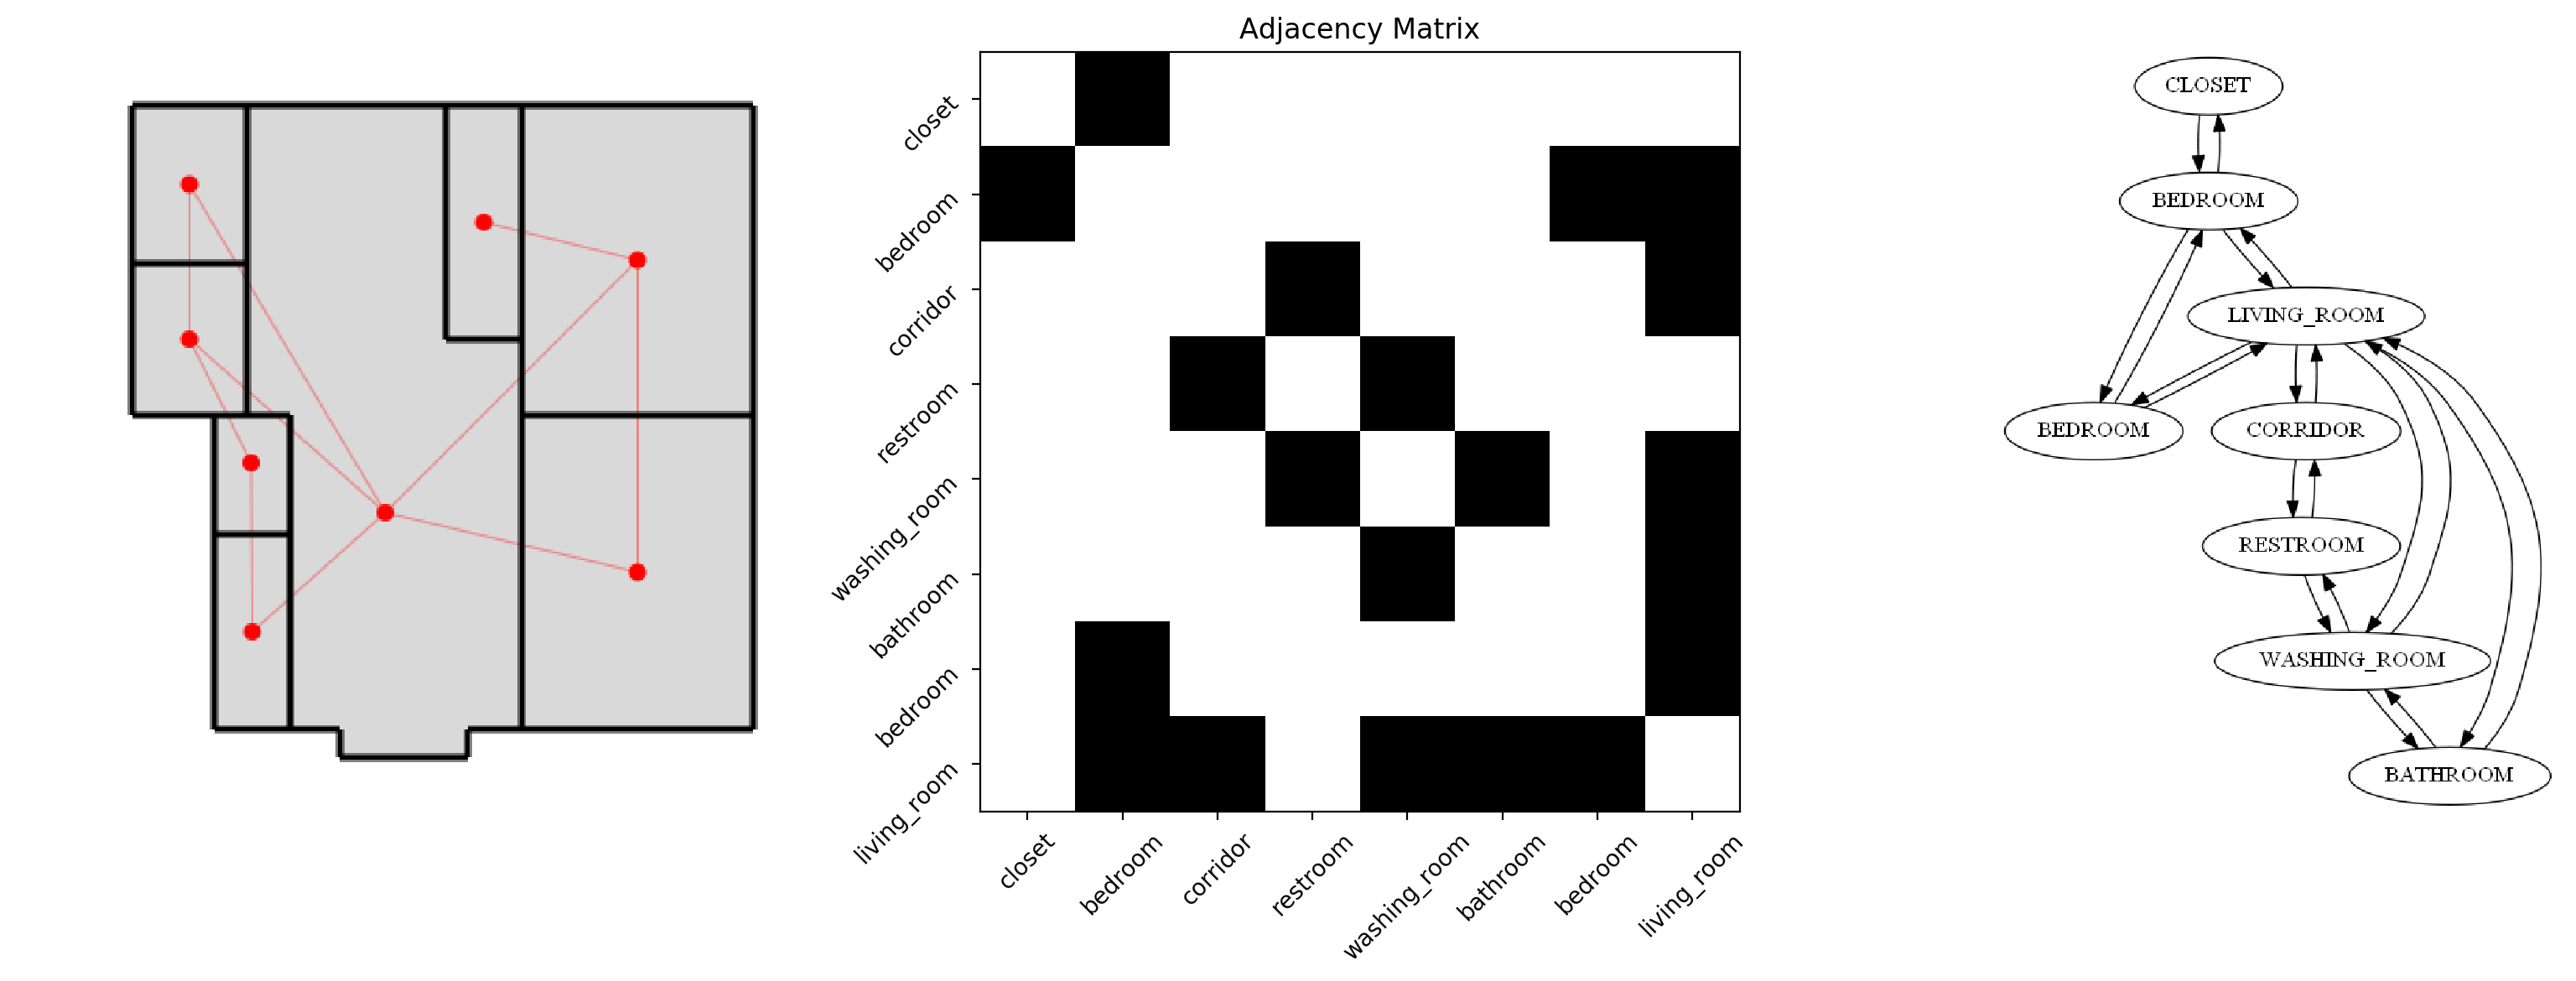

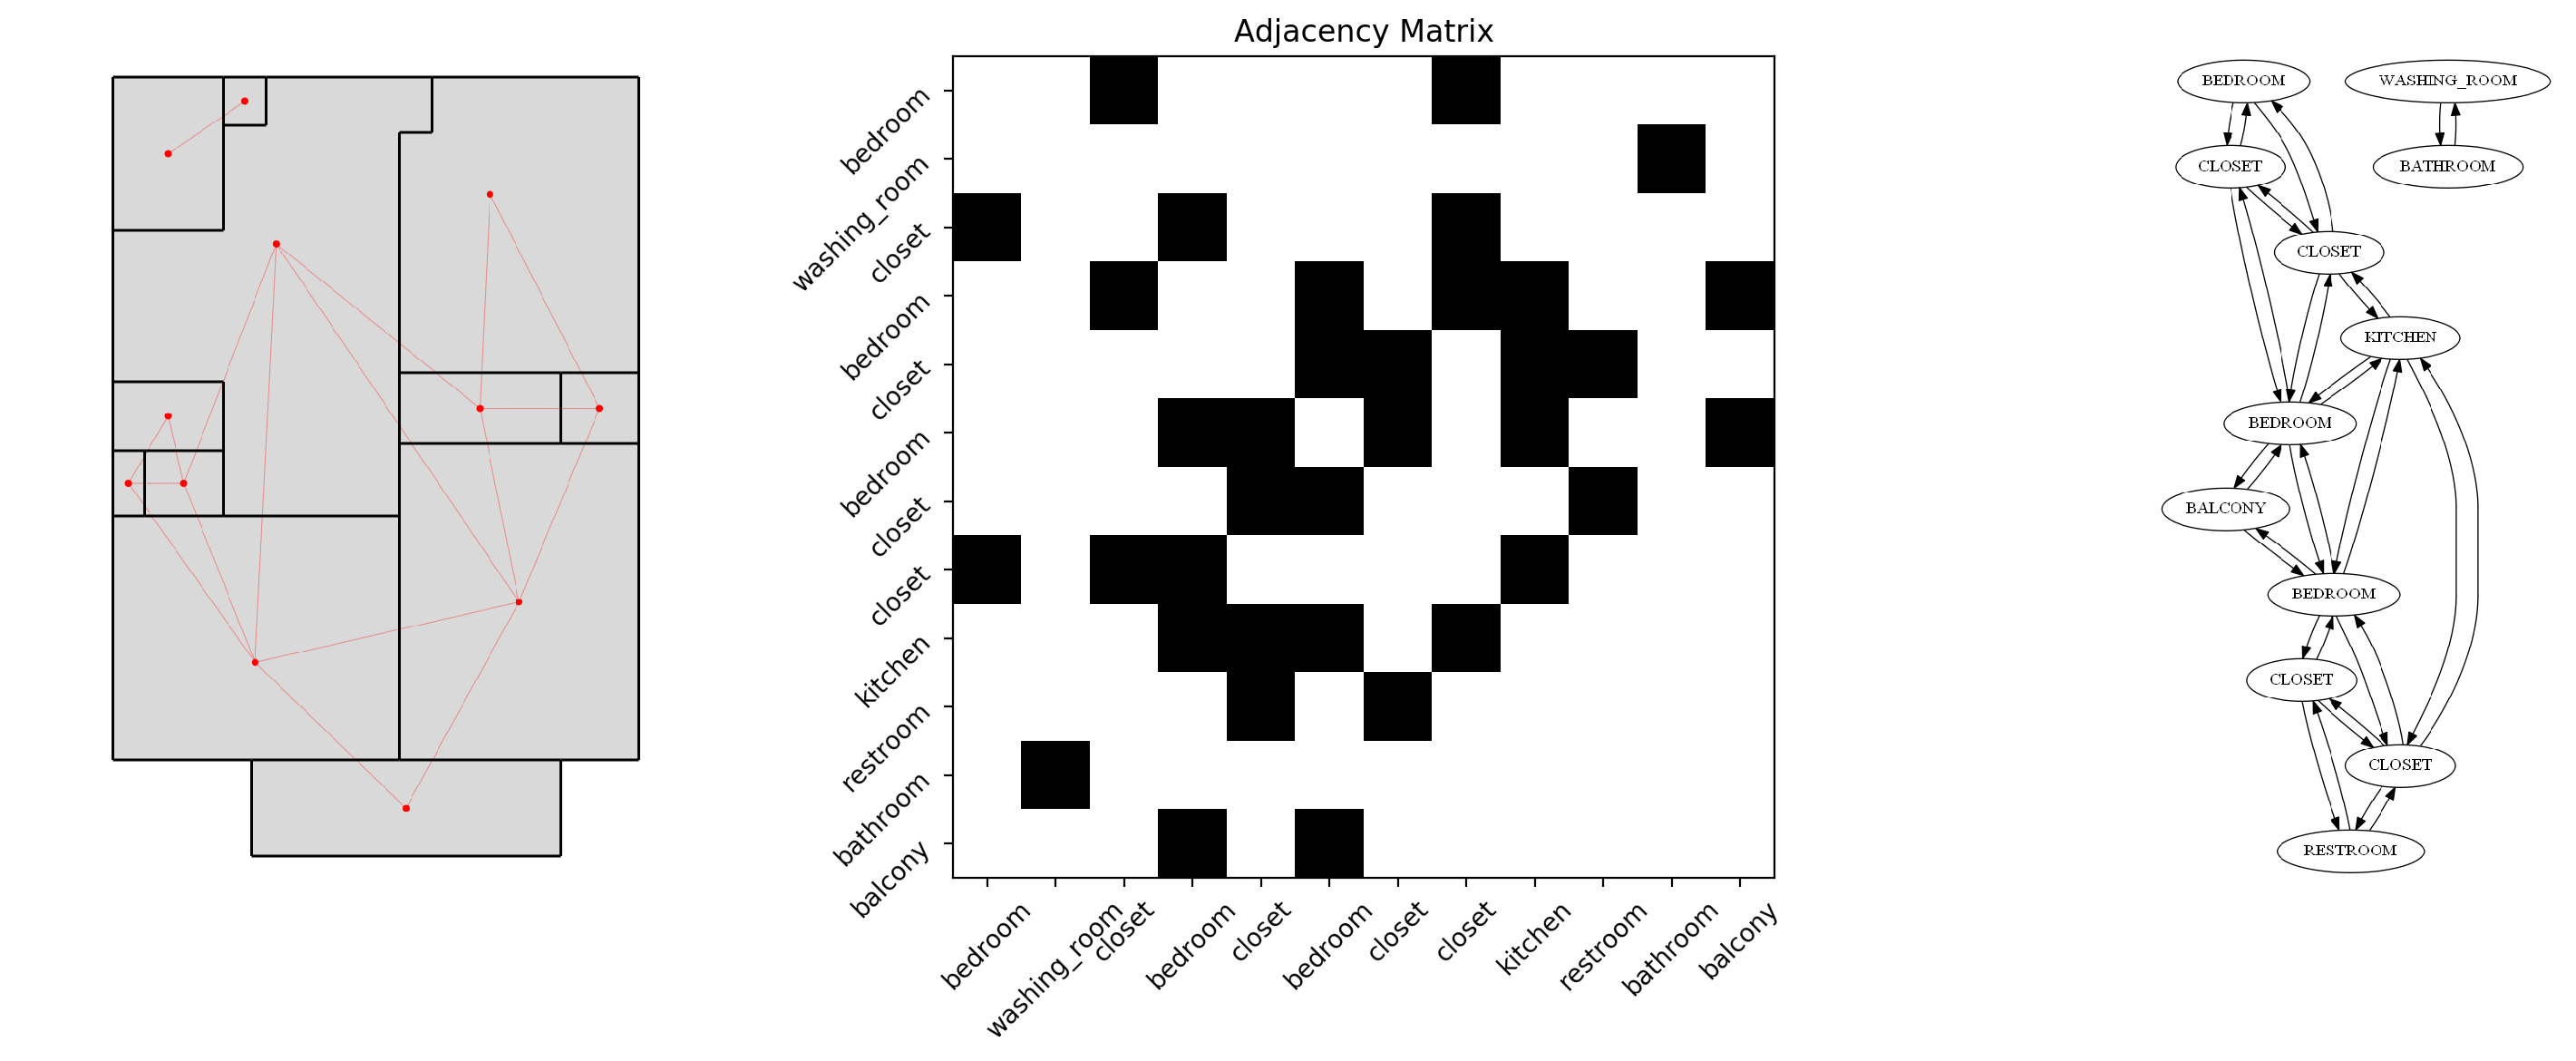

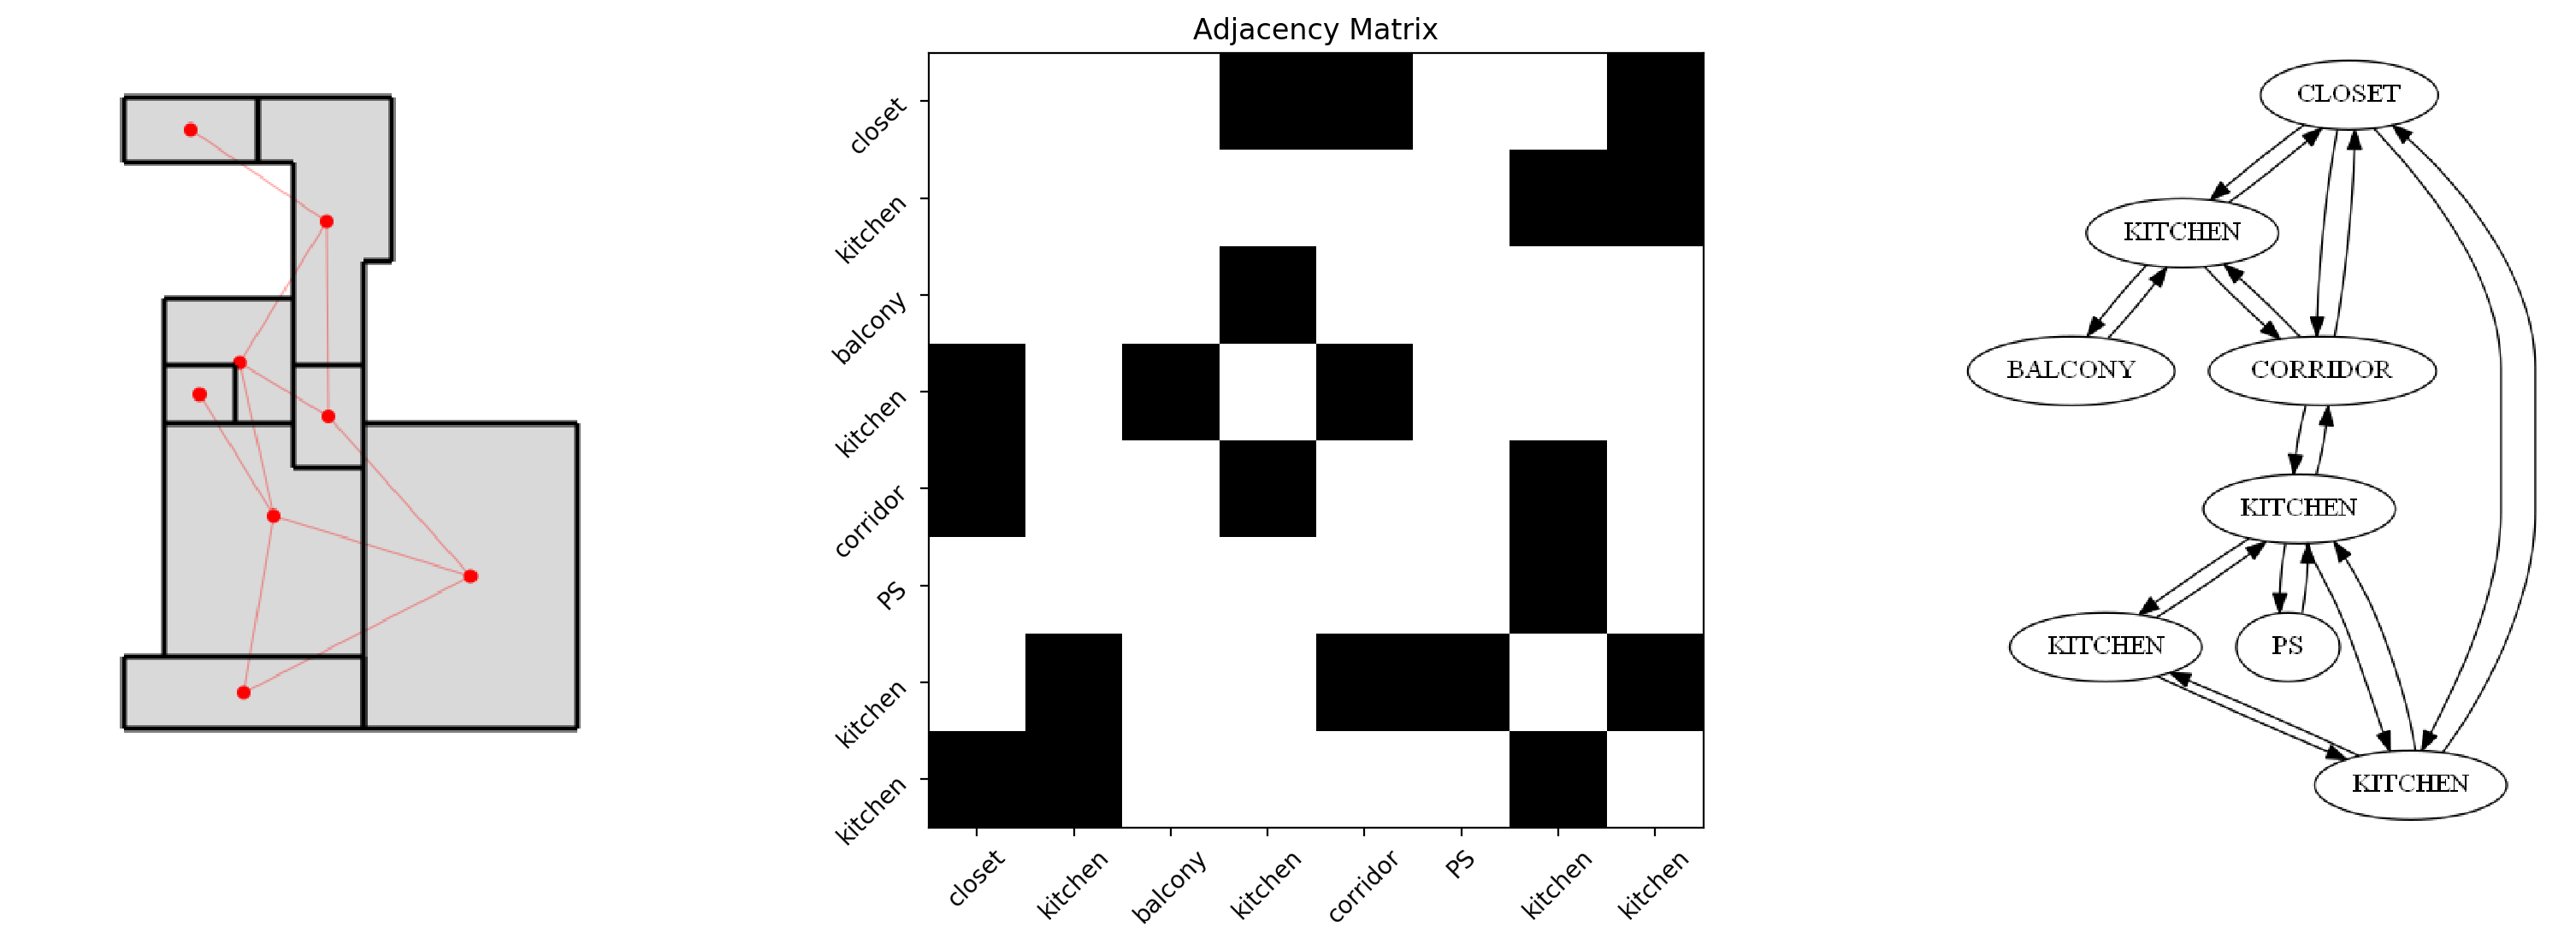

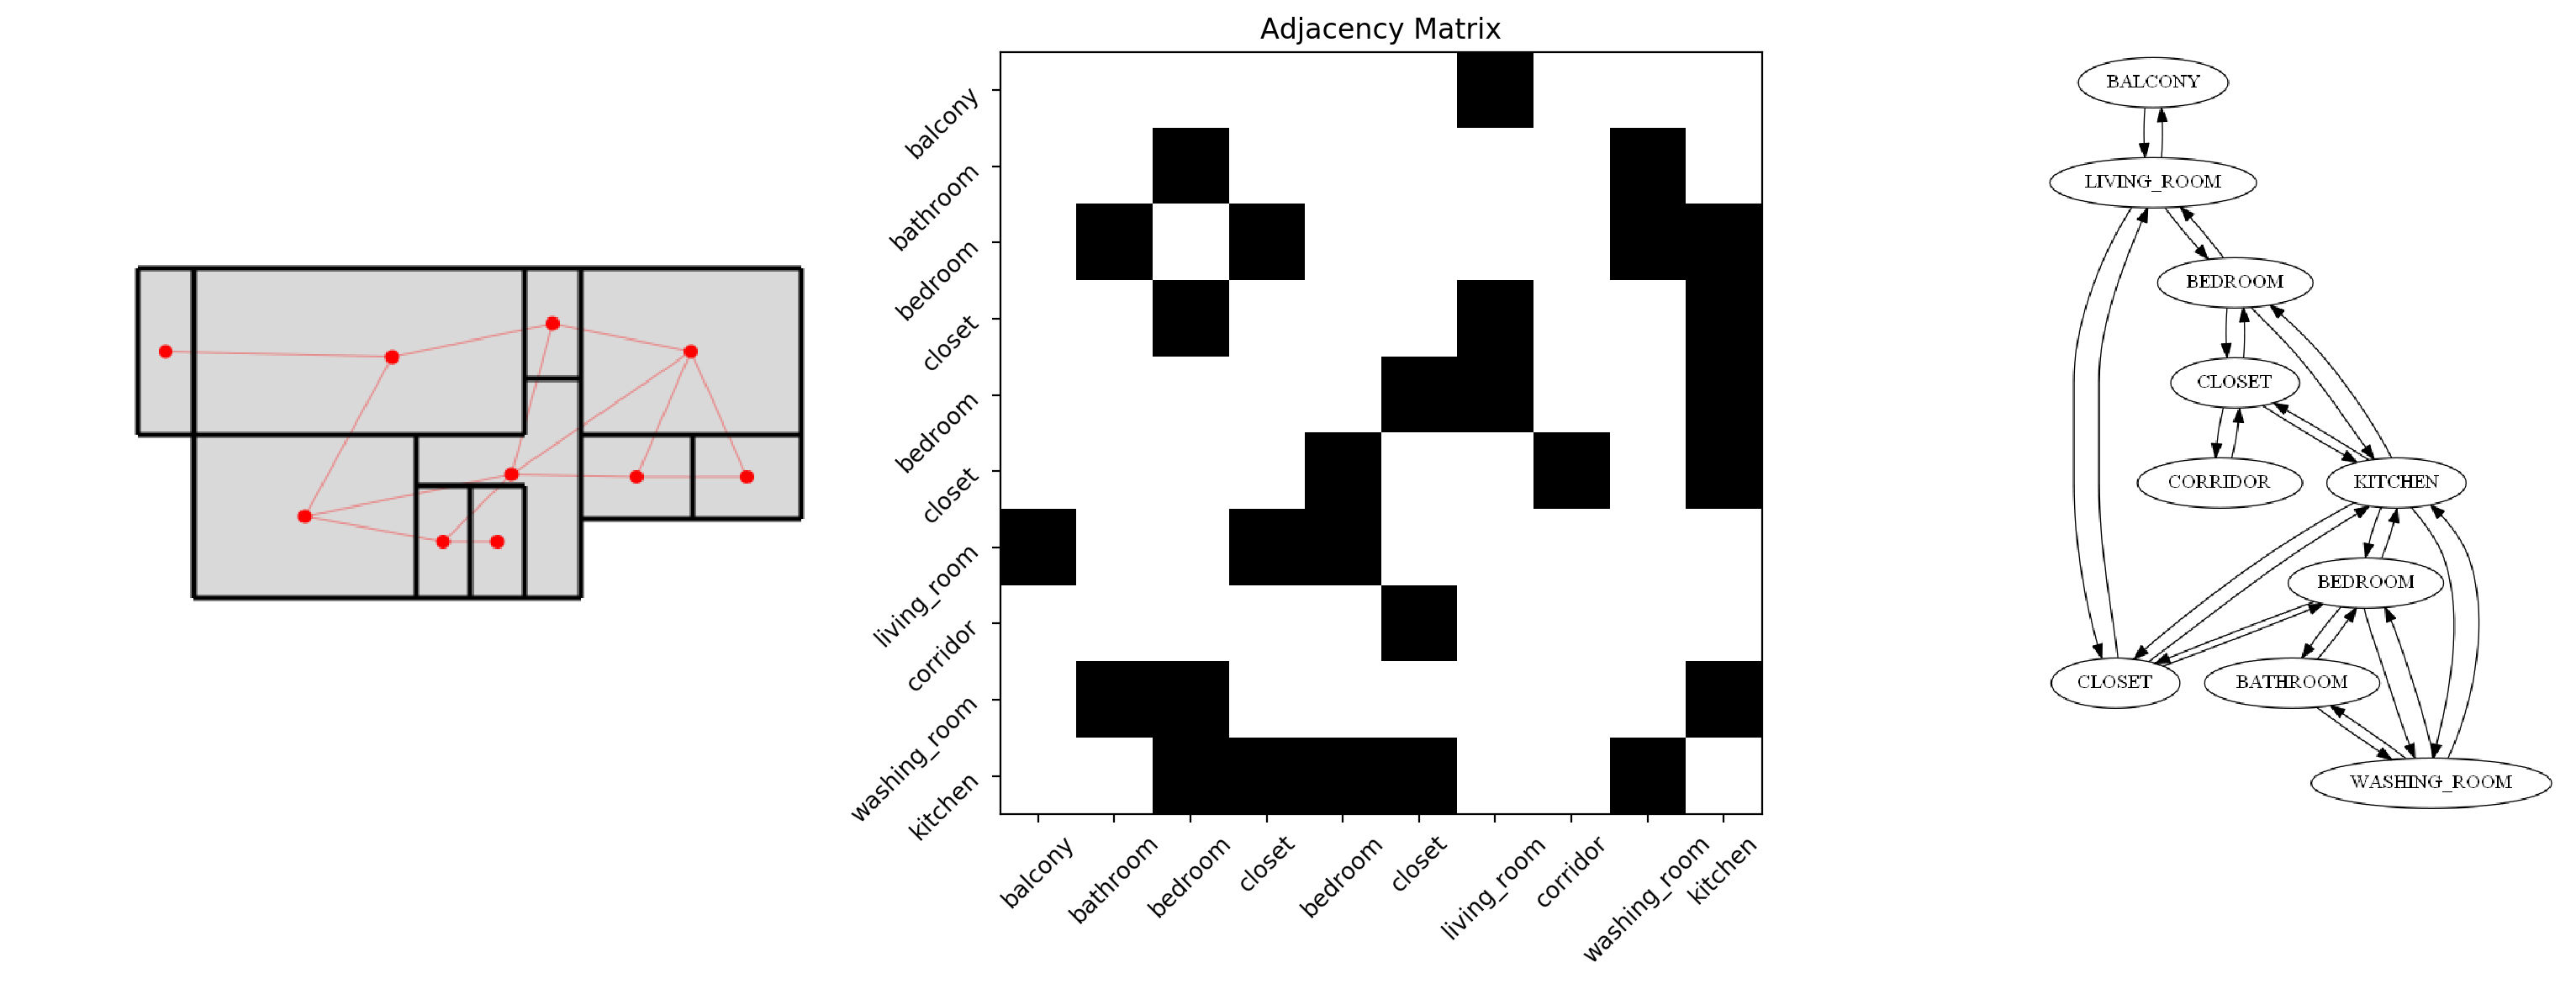

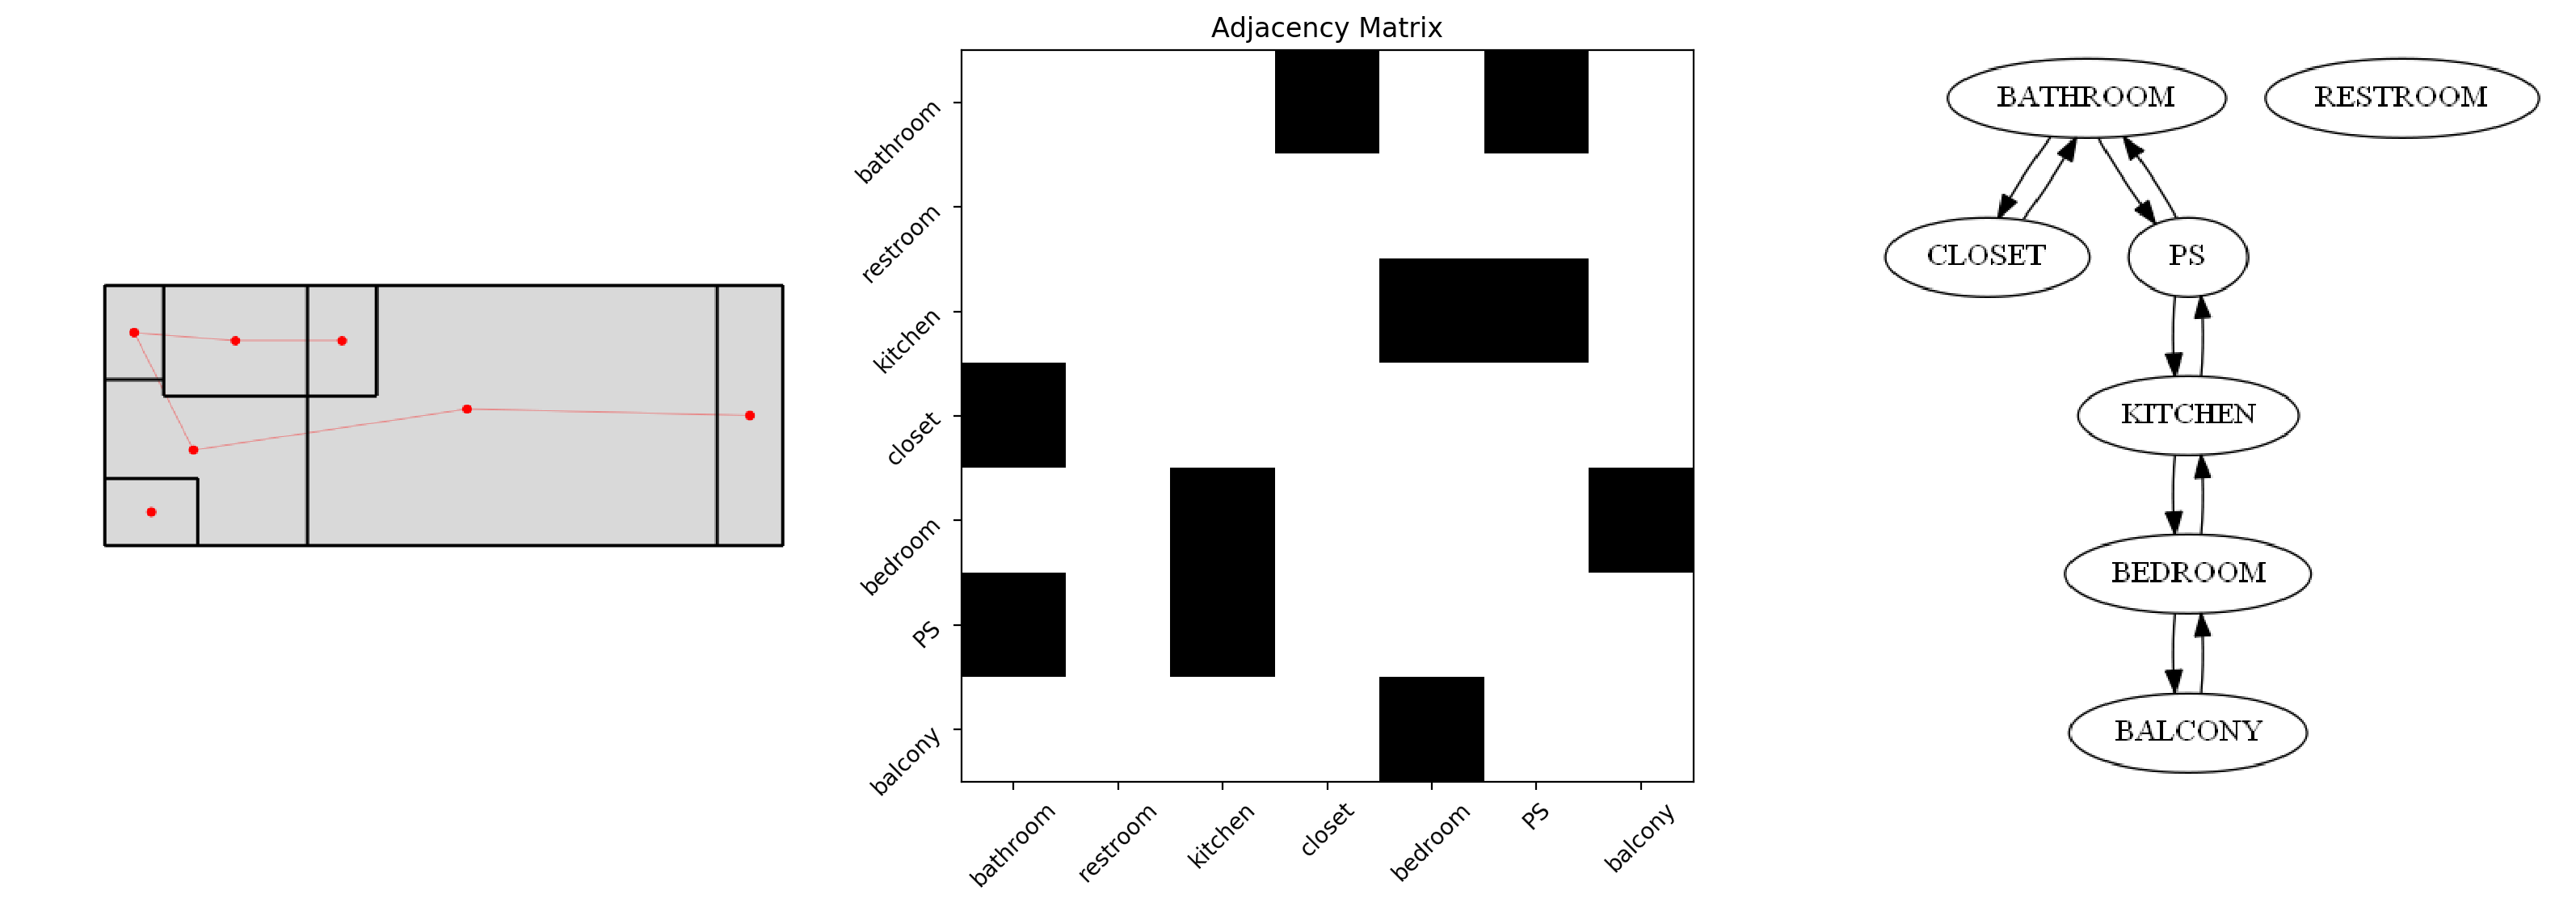

In [29]:
for id_image in range(0,10):
    adj = get_adjacencies(id_image,data_list,save_=False)